# Downloading and importing libraries

In [ ]:
!pip install torch_geometric
!pip install chemprop==1.6.1
!pip install scikit-learn==1.3.2
!pip install rdkit==2024.9.5
!pip install plotly
!pip install umap-learn
!pip install shap
!pip install mordred

In [29]:
# python analyses
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import requests
import time

# machine learning analysis and pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, Matern, ConstantKernel, RBF
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import auc
import umap

import xgboost

# deep learning
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import   Data, DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.utils import degree
from torch_geometric.data import Batch
from torch_geometric.nn import MessagePassing
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

from chemprop.features import load_features
from chemprop.models import MoleculeModel
from chemprop.train import run_training
from chemprop.args import TrainArgs
import chemprop
from chemprop import data

from scipy.stats import chi2_contingency
from scipy.stats import gaussian_kde
from scipy.stats import pearsonr
from scipy.stats import spearmanr

# for cheminformatics handling
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools

# for interactive plots
import plotly.express as px
import plotly.graph_objects as go

import shap

import seaborn as sns
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# functions

In [ ]:
def train_mlp_with_early_stopping(X_train, X_val, y_train, y_val, epochs=100, patience=10):
    mlp = MLPRegressor(hidden_layer_sizes=(300, 200, 32,16), # 400, 200, 50,
                        max_iter=1,  # We will manually handle epochs
                        warm_start=True,  # Keep existing model when calling fit multiple times
                        random_state=42,
                          alpha=0.01,
                        learning_rate='adaptive',
                      learning_rate_init = 0.001)

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        mlp.fit(X_train, y_train)

        y_train_pred = mlp.predict(X_train)
        y_val_pred = mlp.predict(X_val)

        train_loss = mean_squared_error(y_train, y_train_pred)
        val_loss = mean_squared_error(y_val, y_val_pred)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return mlp, train_losses, val_losses

# Function to compute ECFP fingerprints
def calculate_ecfp(df, smiles_column="Smiles", radius=3, n_bits=1024):
    """
    Computes the ECFP (Morgan fingerprint) for SMILES in a dataset.

    :param df: Pandas DataFrame containing SMILES strings.
    :param smiles_column: Column containing SMILES.
    :param radius: Radius for Morgan fingerprint.
    :param n_bits: Number of bits in the fingerprint.
    :return: DataFrame with ECFP features.
    """
    fingerprints = []
    valid_smiles = []

    for smiles in df[smiles_column].dropna():
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
            fingerprints.append(np.array(fp))  # Convert to NumPy array
            valid_smiles.append(smiles)

    # Convert to DataFrame
    ecfp_df = pd.DataFrame(fingerprints, columns=[f"Bit_{i}" for i in range(n_bits)])

    return ecfp_df

# Function to compute all RDKit descriptors
def calculate_rdkit_descriptors(df, smiles_column="Smiles"):
    """
    Computes all RDKit descriptors for SMILES in a dataset.

    :param df: Pandas DataFrame containing SMILES strings.
    :param smiles_column: Column containing SMILES.
    :return: DataFrame with RDKit descriptors.
    """
    descriptor_names = [desc[0] for desc in Descriptors.descList]  # Get descriptor names
    descriptors_list = []
    valid_smiles = []

    for smiles in df[smiles_column].dropna():
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            descriptor_values = [desc[1](mol) for desc in Descriptors.descList]  # Compute descriptors
            descriptors_list.append(descriptor_values)
            valid_smiles.append(smiles)

    # Convert to DataFrame
    descriptors_df = pd.DataFrame(descriptors_list, columns=descriptor_names)

    return descriptors_df




In [ ]:
### function to calculate physicochemical properties
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors, QED, FindMolChiralCenters
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit.Chem import rdDistGeom, rdFreeSASA
from rdkit.Chem.rdmolops import GetFormalCharge
from itertools import combinations
import numpy as np
import pandas as pd

def fused_ring_count(m):
    """Count the number of fused rings in a molecule."""
    q = m.GetRingInfo()
    rings = [set(r) for r in q.AtomRings()]
    go_next = True
    while go_next:
        go_next = False
        for i, j in combinations(range(len(rings)), 2):
            if rings[i] & rings[j]:
                q = rings[i] | rings[j]
                del rings[j], rings[i]
                rings.append(q)
                go_next = True
                break
    return len(rings)

def count_hbd_hba_atoms(m):
    """Count the number of hydrogen bond donor and acceptor atoms."""
    HDonorSmarts = Chem.MolFromSmarts('[$([N;!H0;v3]),$([N;!H0;+1;v4]),$([O,S;H1;+0]),$([n;H1;+0])]')
    HAcceptorSmarts = Chem.MolFromSmarts('[$([O,S;H1;v2]-[!$(*=[O,N,P,S])]),' +
                                         '$([O,S;H0;v2]),$([O,S;-]),$([N;v3;!$(N-*=!@[O,N,P,S])]),' +
                                         '$([nH0,o,s;+0])]')
    HDonor = m.GetSubstructMatches(HDonorSmarts)
    HAcceptor = m.GetSubstructMatches(HAcceptorSmarts)
    return len(set(HDonor + HAcceptor))

def confgen(smile, prunermsthresh=0.1, numconf=20):
    """Generate conformers for a given molecule."""
    mol = Chem.AddHs(Chem.MolFromSmiles(smile), addCoords=True)
    param = rdDistGeom.ETKDGv2()
    param.pruneRmsThresh = prunermsthresh
    cids = rdDistGeom.EmbedMultipleConfs(mol, numconf, param)
    mp = AllChem.MMFFGetMoleculeProperties(mol, mmffVariant='MMFF94s')
    AllChem.MMFFOptimizeMoleculeConfs(mol, numThreads=4, mmffVariant='MMFF94s')
    return mol

def calc_globularity_pbf(mol):
    """Calculate globularity and PBF for a molecule."""
    glob_ls = []
    pbf_ls = []
    for i in range(len(mol.GetConformers())):
        radii1 = rdFreeSASA.classifyAtoms(mol)
        sasa = rdFreeSASA.CalcSASA(mol, radii1, confIdx=i)
        molv = AllChem.ComputeMolVolume(mol, confId=i)
        globularity = ((molv * 3 / (4 * np.pi)) ** (2 / 3)) * 4 * np.pi / sasa
        pbf = rdMolDescriptors.CalcPBF(mol, confId=i)
        glob_ls.append(globularity)
        pbf_ls.append(pbf)
    return np.mean(np.asarray(glob_ls)), np.mean(np.asarray(pbf_ls))

def calc_descriptors(smiles_series):
    """
    Calculate molecular descriptors for a pandas Series of SMILES strings.
    :param smiles_series: pandas Series of SMILES strings.
    :return: DataFrame of molecular descriptors.
    """
    descriptors = []
    columns = ['HBA', 'HBD', 'HBA+HBD', 'NumRings', 'RTB', 'NumAmideBonds',
               'Globularity', 'PBF', 'TPSA', 'logP', 'MR', 'MW', 'Csp3',
               'fmf', 'QED', 'HAC', 'NumRingsFused', 'unique_HBAD', 'max_ring_size',
               'n_chiral_centers', 'fcsp3_bm', 'formal_charge', 'abs_charge']

    for smi in smiles_series:
        m = Chem.MolFromSmiles(smi)
        if m is not None:
            try:
                m = confgen(smi)
                hba = rdMolDescriptors.CalcNumHBA(m)
                hbd = rdMolDescriptors.CalcNumHBD(m)
                nrings = rdMolDescriptors.CalcNumRings(m)
                rtb = rdMolDescriptors.CalcNumRotatableBonds(m)
                glob, pbf = calc_globularity_pbf(m)
                psa = rdMolDescriptors.CalcTPSA(m)
                logp, mr = rdMolDescriptors.CalcCrippenDescriptors(m)
                mw = rdMolDescriptors._CalcMolWt(m)
                csp3 = rdMolDescriptors.CalcFractionCSP3(m)
                hac = m.GetNumHeavyAtoms()
                fmf = GetScaffoldForMol(m).GetNumHeavyAtoms() / hac if hac > 0 else 0
                qed = QED.qed(m)
                nrings_fused = fused_ring_count(m)
                n_unique_hba_hbd_atoms = count_hbd_hba_atoms(m)
                max_ring_size = len(max(m.GetRingInfo().AtomRings(), key=len, default=()))
                n_chiral_centers = len(FindMolChiralCenters(m, includeUnassigned=True))
                fcsp3_bm = rdMolDescriptors.CalcFractionCSP3(GetScaffoldForMol(m))
                n_amide_bond = rdMolDescriptors.CalcNumAmideBonds(m)
                f_charge = GetFormalCharge(m)
                abs_charge = abs(f_charge)
                descriptors.append([hba, hbd, hba + hbd, nrings, rtb, n_amide_bond, glob, pbf,
                                    psa, logp, mr, mw, csp3, fmf, qed, hac, nrings_fused,
                                    n_unique_hba_hbd_atoms, max_ring_size, n_chiral_centers,
                                    fcsp3_bm, f_charge, abs_charge])
            except:
                descriptors.append([None] * len(columns))
        else:
            descriptors.append([None] * len(columns))

    return pd.DataFrame(descriptors, columns=columns)


# ML models comparison analysis

run ML modeling script before this to get appropriate indices matching

### ECFP

In [26]:
# Loading the dataset
csv_path = "PhD paper data with SMILES.csv"
df = pd.read_csv(csv_path)

# Computing ECFP fingerprints
X_ecfp = calculate_ecfp(df)
y_mtb1600 = df['MTB Standardized Residuals']
#y_mtb1600 = df_mtb_1600['MTB Standardized Residuals']
y_ecfp = y_mtb1600.copy()

# Extracting the same indices from the existing splits
X_train_ecfp = X_ecfp.loc[X_train.index]
X_val_ecfp = X_ecfp.loc[X_val.index]
X_test_ecfp = X_ecfp.loc[X_test.index]

y_train_ecfp = y_ecfp.loc[X_train.index]
y_val_ecfp = y_ecfp.loc[X_val.index]
y_test_ecfp = y_ecfp.loc[X_test.index]

# XGBoost model on ECFP fingerprints
xgb_model = xgboost.XGBRegressor(random_state=42, max_depth=3, reg_alpha=50)
xgb_model.fit(X_train_ecfp, y_train_ecfp)

# Predictions
y_pred_ecfp_train = xgb_model.predict(X_train_ecfp)
y_pred_ecfp_test = xgb_model.predict(X_test_ecfp)
y_pred_ecfp_val = xgb_model.predict(X_val_ecfp)

# Model evaluation
r2_train_rfecfp = r2_score(y_train_ecfp, y_pred_ecfp_train)
r2_test_rfecfp = r2_score(y_test_ecfp, y_pred_ecfp_test)
r2_val_rfecfp = r2_score(y_val_ecfp, y_pred_ecfp_val)

print("r2 for XGB on ECFP (train, val and test):", r2_train_rfecfp, r2_val_rfecfp,
      r2_test_rfecfp)

# XGBoost model training on ECFP fingerprints
rf_model = RandomForestRegressor(random_state=42, max_depth=4, min_samples_split=5)
rf_model.fit(X_train_ecfp, y_train_ecfp)

# Predictions
y_pred_ecfp_train = rf_model.predict(X_train_ecfp)
y_pred_ecfp_test = rf_model.predict(X_test_ecfp)
y_pred_ecfp_val = rf_model.predict(X_val_ecfp)

# Model evaluation
r2_train_xgbecfp = r2_score(y_train_ecfp, y_pred_ecfp_train)
r2_test_xgbecfp = r2_score(y_test_ecfp, y_pred_ecfp_test)
r2_val_xgbecfp = r2_score(y_val_ecfp, y_pred_ecfp_val)

print("r2 for RF on ECFP (train, val and test):", r2_train_xgbecfp, r2_val_xgbecfp, r2_test_xgbecfp)


[18:28:52] DEPRECATION WARNING: please use MorganGenerator
[18:28:52] DEPRECATION WARNING: please use MorganGenerator
[18:28:52] DEPRECATION WARNING: please use MorganGenerator
[18:28:52] DEPRECATION WARNING: please use MorganGenerator
[18:28:52] DEPRECATION WARNING: please use MorganGenerator
[18:28:52] DEPRECATION WARNING: please use MorganGenerator
[18:28:52] DEPRECATION WARNING: please use MorganGenerator
[18:28:52] DEPRECATION WARNING: please use MorganGenerator
[18:28:52] DEPRECATION WARNING: please use MorganGenerator
[18:28:52] DEPRECATION WARNING: please use MorganGenerator
[18:28:52] DEPRECATION WARNING: please use MorganGenerator
[18:28:52] DEPRECATION WARNING: please use MorganGenerator
[18:28:52] DEPRECATION WARNING: please use MorganGenerator
[18:28:52] DEPRECATION WARNING: please use MorganGenerator
[18:28:52] DEPRECATION WARNING: please use MorganGenerator
[18:28:52] DEPRECATION WARNING: please use MorganGenerator
[18:28:52] DEPRECATION WARNING: please use MorganGenerat

r2 for XGB on ECFP (train, val and test): 0.2767261777358031 0.2501561149974434 0.325236134574596
r2 for RF on ECFP (train, val and test): 0.36520080797472554 0.28479192291279953 0.3471101403331843


### Embeddings

In [27]:
## RF

rf_emb = RandomForestRegressor(max_depth=4, min_samples_split=5,
                               random_state=42)
rf_emb.fit(X_train, y_train)

y_val_pred = rf_emb.predict(X_val)
y_test_pred = rf_emb.predict(X_test)
y_train_pred = rf_emb.predict(X_train)

r2_val_rfemb = r2_score(y_val, y_val_pred)
r2_train_rfemb = r2_score(y_train, y_train_pred)
r2_test_rfemb = r2_score(y_test, y_test_pred)
print('r2 for RF on embeddings (train, val and test): ',r2_train_rfemb, r2_val_rfemb, r2_test_rfemb )

## XGB

xg_emb = xgboost.XGBRegressor(max_depth=2,learning_rate=0.1,
                          reg_lambda = 0.1, random_state=42)
xg_emb.fit(X_train, y_train)

y_val_pred = xg_emb.predict(X_val)
y_test_pred = xg_emb.predict(X_test)
y_train_pred = xg_emb.predict(X_train)



r2_val_xgbemb = r2_score(y_val, y_val_pred)
r2_train_xgbemb = r2_score(y_train, y_train_pred)
r2_test_xgbemb = r2_score(y_test, y_test_pred)
print('r2 for XGB on embeddings (train, val and test): ',r2_train_xgbemb, r2_val_xgbemb,
      r2_test_xgbemb )

## MLP
y_val_pred = mlp_optimal.predict(X_val)
y_test_pred = mlp_optimal.predict(X_test)
y_train_pred = mlp_optimal.predict(X_train)
r2_val_mlpemb = r2_score(y_val, y_val_pred)
r2_train_mlpemb = r2_score(y_train, y_train_pred)
r2_test_mlpemb = r2_score(y_test, y_test_pred)
print('r2 for MLP on embeddings (train, val and test): ',r2_train_mlpemb, r2_val_mlpemb, r2_test_mlpemb )


r2 for RF on embeddings (train, val and test):  0.6908641729564295 0.6059014630745241 0.6650465645995737
r2 for XGB on embeddings (train, val and test):  0.7739234674701858 0.6726762374928686 0.712103824551729
r2 for MLP on embeddings (train, val and test):  0.7446394552545534 0.7106511568458553 0.7244501136244967


### Descriptors

In [31]:
 # RDKit 200 features
# Compute RDKit descriptors

rdkit_desc_df = calculate_rdkit_descriptors(df)
X_rdkit = rdkit_desc_df.iloc[:,1::]
y_rdkit = y_mtb1600.copy()

# Extracting the same indices from the existing splits
X_train_rdkit = X_rdkit.loc[X_train.index]
X_val_rdkit = X_rdkit.loc[X_val.index]
X_test_rdkit = X_rdkit.loc[X_test.index]

y_train_rdkit = y_rdkit.loc[X_train.index]
y_val_rdkit = y_rdkit.loc[X_val.index]
y_test_rdkit = y_rdkit.loc[X_test.index]

# XGBoost model training on RDKit descriptors
xgb_model_rdkit = xgboost.XGBRegressor(random_state=42, max_depth=3, reg_alpha=50)
xgb_model_rdkit.fit(X_train_rdkit, y_train_rdkit)

# Predictions
y_pred_rdkit_train = xgb_model_rdkit.predict(X_train_rdkit)
y_pred_rdkit_test = xgb_model_rdkit.predict(X_test_rdkit)
y_pred_rdkit_val = xgb_model_rdkit.predict(X_val_rdkit)

# Model evaluations
r2_train_xgbrdkit = r2_score(y_train_rdkit, y_pred_rdkit_train)
r2_test_xgbrdkit = r2_score(y_test_rdkit, y_pred_rdkit_test)
r2_val_xgbrdkit = r2_score(y_val_rdkit, y_pred_rdkit_val)

print("r2 for XGB on RDKit Descriptors (train, val and test):", r2_train_xgbrdkit, r2_val_xgbrdkit, r2_test_xgbrdkit)

# RF model training on RDKit descriptors
rf_model_rdkit = RandomForestRegressor(max_depth=4, min_samples_split=5,
                               random_state=42)

rf_model_rdkit.fit(X_train_rdkit, y_train_rdkit)

# Predictions
y_pred_rdkit_train = rf_model_rdkit.predict(X_train_rdkit)
y_pred_rdkit_test = rf_model_rdkit.predict(X_test_rdkit)
y_pred_rdkit_val = rf_model_rdkit.predict(X_val_rdkit)

# Model evaluation
r2_train_rfrdkit = r2_score(y_train_rdkit, y_pred_rdkit_train)
r2_test_rfrdkit = r2_score(y_test_rdkit, y_pred_rdkit_test)
r2_val_rfrdkit = r2_score(y_val_rdkit, y_pred_rdkit_val)

print("r2 for RF on RDKit Descriptors (train, val and test):", r2_train_rfrdkit,r2_val_rfrdkit, r2_test_rfrdkit)


r2 for XGB on RDKit Descriptors (train, val and test): 0.5595008555071463 0.5078103022067596 0.5641789490162274
r2 for RF on RDKit Descriptors (train, val and test): 0.5705338267816347 0.5051607815346624 0.5323769352609302


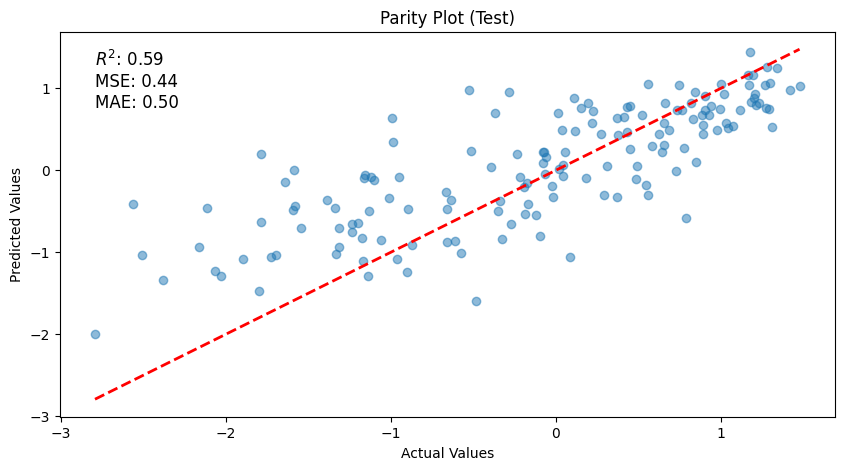

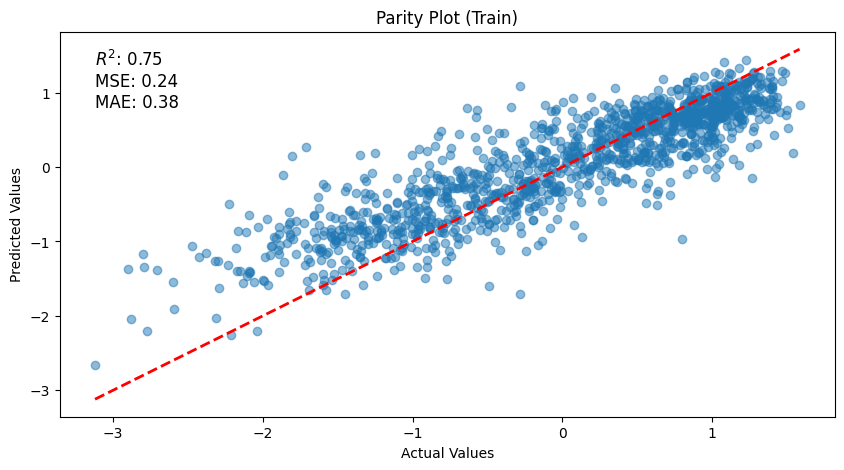

In [33]:
#### MLP on descriptors

np.random.seed(42)
# Standardizing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_rdkit)
X_val_scaled = scaler.transform(X_val_rdkit)
X_test_scaled = scaler.transform(X_test_rdkit)

mlp_optimized = MLPRegressor(hidden_layer_sizes=(128, 64, 32),
                             activation='relu',  # Better for deep models
                             solver='adam',  # Adaptive optimization
                             alpha=0.1,  # L2 regularization to prevent overfitting
                             learning_rate_init=0.01,
                             max_iter=100,
                             warm_start=True,
                             random_state=42)

# Training loop with early stopping
epochs = 200
patience = 10
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    # Adding small Gaussian noise to prevent overfitting
    noise = np.random.normal(0, 0.01, X_train_scaled.shape)
    mlp_optimized.fit(X_train_scaled + noise, y_train_rdkit)

    y_train_pred = mlp_optimized.predict(X_train_scaled)
    y_val_pred = mlp_optimized.predict(X_val_scaled)

    train_loss = mean_squared_error(y_train_rdkit, y_train_pred)
    val_loss = mean_squared_error(y_val_rdkit, y_val_pred)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Early stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        break

# final model evaluation
y_test_pred = mlp_optimized.predict(X_test_scaled)

train_mse = mean_squared_error(y_train_rdkit, y_train_pred)
val_mse = mean_squared_error(y_val_rdkit, y_val_pred)
test_mse = mean_squared_error(y_test_rdkit, y_test_pred)

train_r2 = r2_score(y_train_rdkit, y_train_pred)
val_r2 = r2_score(y_val_rdkit, y_val_pred)
test_r2 = r2_score(y_test_rdkit, y_test_pred)

train_mae = mean_absolute_error(y_train_rdkit, y_train_pred)
val_mae = mean_absolute_error(y_val_rdkit, y_val_pred)
test_mae = mean_absolute_error(y_test_rdkit, y_test_pred)

# Parity plot (Test)
plt.figure(figsize=(10, 5))
plt.scatter(y_test_rdkit, y_test_pred, alpha=0.5)
plt.plot([y_test_rdkit.min(), y_test_rdkit.max()], [y_test_rdkit.min(), y_test_rdkit.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Parity Plot (Test)')
plt.text(y_test_rdkit.min(), y_test_rdkit.max(), f'$R^2$: {test_r2:.2f}\nMSE: {test_mse:.2f}\nMAE: {test_mae:.2f}',
         fontsize=12, verticalalignment='top')
plt.show()

# Parity plot (Train)
plt.figure(figsize=(10, 5))
plt.scatter(y_train_rdkit, y_train_pred, alpha=0.5)
plt.plot([y_train_rdkit.min(), y_train_rdkit.max()], [y_train_rdkit.min(), y_train_rdkit.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Parity Plot (Train)')
plt.text(y_train_rdkit.min(), y_train_rdkit.max(), f'$R^2$: {train_r2:.2f}\nMSE: {train_mse:.2f}\nMAE: {train_mae:.2f}',
         fontsize=12, verticalalignment='top')
plt.show()

# Return performance metrics

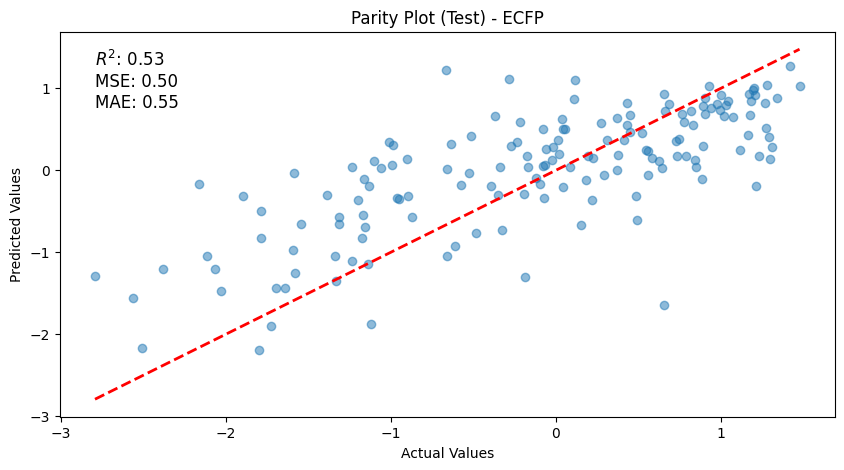

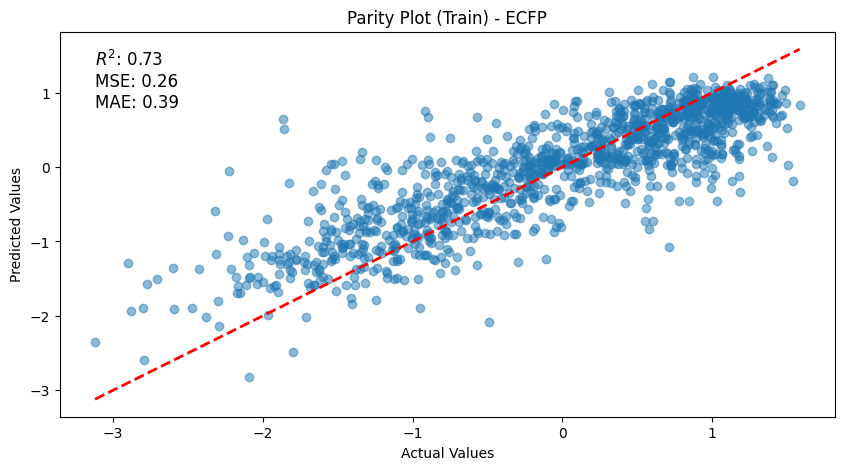

((0.2600842837070963, 0.6429446917626691, 0.49618826951611067),
 (0.7294948190327484, 0.48708934993090847, 0.5344912709833992),
 (0.38887183797765396, 0.6252606547263915, 0.5499937823837888))

In [35]:
## ECFP + Descriptors
np.random.seed(42)

# Standardize ECFP data
scaler_ecfp = StandardScaler()
X_train_ecfp_scaled = scaler_ecfp.fit_transform(X_train_ecfp)
X_val_ecfp_scaled = scaler_ecfp.transform(X_val_ecfp)
X_test_ecfp_scaled = scaler_ecfp.transform(X_test_ecfp)

# Define improved MLP with optimized settings
mlp_ecfp = MLPRegressor(hidden_layer_sizes=(128, 64),  # expressive architecture
                        activation='relu',
                        solver='adam',  # Adaptive optimization
                        alpha=10,  # L2 regularization to prevent overfitting
                        learning_rate_init=0.01,
                        max_iter=100,  # Manually handle epochs
                        warm_start=True,
                        random_state=42)

# Training loop with early stopping
epochs = 200
patience = 10
train_losses_ecfp = []
val_losses_ecfp = []
best_val_loss_ecfp = float('inf')
patience_counter_ecfp = 0

for epoch in range(epochs):
    # Adding small Gaussian noise to prevent overfitting
    noise_ecfp = np.random.normal(0, 0.01, X_train_ecfp_scaled.shape)
    mlp_ecfp.fit(X_train_ecfp_scaled + noise_ecfp, y_train_ecfp)

    y_train_pred_ecfp = mlp_ecfp.predict(X_train_ecfp_scaled)
    y_val_pred_ecfp = mlp_ecfp.predict(X_val_ecfp_scaled)

    train_loss_ecfp = mean_squared_error(y_train_ecfp, y_train_pred_ecfp)
    val_loss_ecfp = mean_squared_error(y_val_ecfp, y_val_pred_ecfp)

    train_losses_ecfp.append(train_loss_ecfp)
    val_losses_ecfp.append(val_loss_ecfp)

    # Early stopping condition
    if val_loss_ecfp < best_val_loss_ecfp:
        best_val_loss_ecfp = val_loss_ecfp
        patience_counter_ecfp = 0
    else:
        patience_counter_ecfp += 1

    if patience_counter_ecfp >= patience:
        break

# Evaluate the final model
y_test_pred_ecfp = mlp_ecfp.predict(X_test_ecfp_scaled)

train_mse_ecfp = mean_squared_error(y_train_ecfp, y_train_pred_ecfp)
val_mse_ecfp = mean_squared_error(y_val_ecfp, y_val_pred_ecfp)
test_mse_ecfp = mean_squared_error(y_test_ecfp, y_test_pred_ecfp)

train_r2_ecfp = r2_score(y_train_ecfp, y_train_pred_ecfp)
val_r2_ecfp = r2_score(y_val_ecfp, y_val_pred_ecfp)
test_r2_ecfp = r2_score(y_test_ecfp, y_test_pred_ecfp)

train_mae_ecfp = mean_absolute_error(y_train_ecfp, y_train_pred_ecfp)
val_mae_ecfp = mean_absolute_error(y_val_ecfp, y_val_pred_ecfp)
test_mae_ecfp = mean_absolute_error(y_test_ecfp, y_test_pred_ecfp)

# Parity plot (Test)
plt.figure(figsize=(10, 5))
plt.scatter(y_test_ecfp, y_test_pred_ecfp, alpha=0.5)
plt.plot([y_test_ecfp.min(), y_test_ecfp.max()], [y_test_ecfp.min(), y_test_ecfp.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Parity Plot (Test) - ECFP')
plt.text(y_test_ecfp.min(), y_test_ecfp.max(), f'$R^2$: {test_r2_ecfp:.2f}\nMSE: {test_mse_ecfp:.2f}\nMAE: {test_mae_ecfp:.2f}',
         fontsize=12, verticalalignment='top')
plt.show()

# Parity plot (Train)
plt.figure(figsize=(10, 5))
plt.scatter(y_train_ecfp, y_train_pred_ecfp, alpha=0.5)
plt.plot([y_train_ecfp.min(), y_train_ecfp.max()], [y_train_ecfp.min(), y_train_ecfp.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Parity Plot (Train) - ECFP')
plt.text(y_train_ecfp.min(), y_train_ecfp.max(), f'$R^2$: {train_r2_ecfp:.2f}\nMSE: {train_mse_ecfp:.2f}\nMAE: {train_mae_ecfp:.2f}',
         fontsize=12, verticalalignment='top')
plt.show()

# Return performance metrics
(train_mse_ecfp, val_mse_ecfp, test_mse_ecfp), (train_r2_ecfp, val_r2_ecfp, test_r2_ecfp), (train_mae_ecfp, val_mae_ecfp, test_mae_ecfp)

### Plotting the different ML models

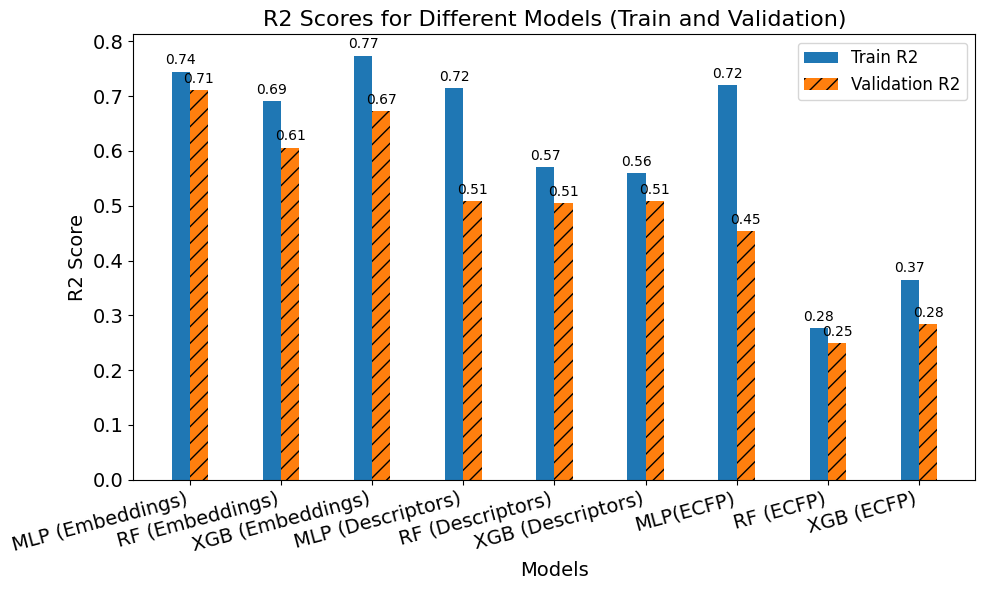

In [ ]:
# Updated Data for plotting
models = ['MLP (Embeddings)',  'RF (Embeddings)','XGB (Embeddings)', 'MLP (Descriptors)', 'RF (Descriptors)', 'XGB (Descriptors)', 'MLP(ECFP)','RF (ECFP)', 'XGB (ECFP)']
train_r2 = [r2_train_mlpemb, r2_train_rfemb, r2_train_xgbemb, mlpdesc_train_r2, r2_train_rfrdkit, r2_train_xgbrdkit,train_r2_ecfp, r2_train_rfecfp,r2_train_xgbecfp ]
val_r2 = [r2_val_mlpemb, r2_val_rfemb, r2_val_xgbemb, mlpdesc_val_r2, r2_val_rfrdkit, r2_val_xgbrdkit, val_r2_ecfp, r2_val_rfecfp, r2_val_xgbecfp ]

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Colors and hatch patterns for color-blind accessibility
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
hatches = ['', '//', 'xx']

# Colors and hatch patterns for color-blind accessibility
rects1 = ax.bar(x - width/2, train_r2, width, label='Train R2', color=colors[0], hatch=hatches[0])
rects2 = ax.bar(x + width/2, val_r2, width, label='Validation R2', color=colors[1], hatch=hatches[1])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('R2 Score', fontsize=14)
ax.set_title('R2 Scores for Different Models (Train and Validation)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12, rotation=15, ha='right')
ax.legend(fontsize=12)

# Increase the font size for the tick labels
ax.tick_params(axis='both', which='major', labelsize=14)

# Add bar labels with increased font size
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10)

add_labels(rects1)
add_labels(rects2)

fig.tight_layout()

plt.show()

# 1. Activity vs Permeability Experiments

In [ ]:
mlsmr = pd.read_excel('Prep notebook (Seigrist).xlsx', sheet_name = 'mlsmr')
mlsmr_activity = mlsmr['MTb (H37Rv) Primary Screen @ 10 uM: % Inhibition @ 10 uM (%)']
mlsmr_perm = mlsmr['MLSMR Predictions']
mlsmr_smiles = mlsmr['SMILES']

### MLSMR

### top 15 % and bottom 15%

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

# the number of points for the bottom and top 15%
num_bottom_points = int(len(mlsmr_activity) * 0.15)
num_top_points = int(len(mlsmr_activity) * 0.15)

# Determining thresholds
sorted_activity = mlsmr_activity.sort_values()
bottom_activity_threshold = sorted_activity.iloc[num_bottom_points - 1]  # Bottom 15%
top_activity_threshold = sorted_activity.iloc[-num_top_points]          # Top 15%

# Filtering for points where activity is either in the bottom 15% or the top 15%
filtered_mlsmr = mlsmr[
    (mlsmr_activity <= bottom_activity_threshold) |
    (mlsmr_activity >= top_activity_threshold)
].copy()

# median permeability threshold
perm_threshold = mlsmr_perm.median()

# Correct the permeability category labels:
# Lower numerical values → "High Permeability"
# Higher numerical values → "Low Permeability"
filtered_mlsmr['Permeability Category'] = np.where(
    filtered_mlsmr[mlsmr_perm.name] >= perm_threshold,
    'Low Permeability',
    'High Permeability'
)

# Bin activity into High and Low
filtered_mlsmr['Activity Category'] = np.where(
    filtered_mlsmr[mlsmr_activity.name] >= top_activity_threshold,
    'High Activity',
    'Low Activity'
)

# Verify the counts
num_bottom_points_actual = (mlsmr_activity <= bottom_activity_threshold).sum()
num_top_points_actual = (mlsmr_activity >= top_activity_threshold).sum()
print(f"Number of bottom activity points (<= {bottom_activity_threshold}): {num_bottom_points_actual}")
print(f"Number of top activity points (>= {top_activity_threshold}): {num_top_points_actual}")

# Create a contingency table
contingency_table_1 = pd.crosstab(filtered_mlsmr['Permeability Category'], filtered_mlsmr['Activity Category'])

# Perform the Chi-Squared Test
chi2_1, p_1, dof_1, expected_1 = chi2_contingency(contingency_table_1)

# Display results
print("\nContingency Table:")
print(contingency_table_1)

print("\nChi-Squared Test Results:")
print(f"Chi-Squared Statistic: {chi2_1:.4f}")
print(f"P-Value: {p_1:.10f}")
print(f"Degrees of Freedom: {dof_1}")

print("\nExpected Frequencies:")
print(expected_1)


Number of bottom activity points (<= -6.74): 31938
Number of top activity points (>= 7.84): 31928

Contingency Table:
Activity Category      High Activity  Low Activity
Permeability Category                             
High Permeability              17337         14511
Low Permeability               14591         17427

Chi-Squared Test Results:
Chi-Squared Statistic: 501.6053
P-Value: 0.0000000000
Degrees of Freedom: 1

Expected Frequencies:
[[15921.50665456 15926.49334544]
 [16006.49334544 16011.50665456]]


## top and bottom 10 and 20 percent

In [ ]:

# Calculate the number of points for the bottom and top 15%
num_bottom_points = int(len(mlsmr_activity) * 0.20)
num_top_points = int(len(mlsmr_activity) * 0.20)

# Determine thresholds
sorted_activity = mlsmr_activity.sort_values()
bottom_activity_threshold = sorted_activity.iloc[num_bottom_points - 1]  # Bottom 15%
top_activity_threshold = sorted_activity.iloc[-num_top_points]          # Top 15%

# Filter for points where activity is either in the bottom 15% or the top 15%
filtered_mlsmr = mlsmr[
    (mlsmr_activity <= bottom_activity_threshold) |
    (mlsmr_activity >= top_activity_threshold)
].copy()

# Compute median permeability threshold
perm_threshold = mlsmr_perm.median()

# permeability category labels:
# Lower numerical values → "High Permeability"
# Higher numerical values → "Low Permeability"
filtered_mlsmr['Permeability Category'] = np.where(
    filtered_mlsmr[mlsmr_perm.name] >= perm_threshold,
    'Low Permeability',
    'High Permeability'
)

# Bin activity into High and Low
filtered_mlsmr['Activity Category'] = np.where(
    filtered_mlsmr[mlsmr_activity.name] >= top_activity_threshold,
    'High Activity',
    'Low Activity'
)

# Verifying the counts
num_bottom_points_actual = (mlsmr_activity <= bottom_activity_threshold).sum()
num_top_points_actual = (mlsmr_activity >= top_activity_threshold).sum()
print(f"Number of bottom activity points (<= {bottom_activity_threshold}): {num_bottom_points_actual}")
print(f"Number of top activity points (>= {top_activity_threshold}): {num_top_points_actual}")

# Creating a contingency table
contingency_table_1 = pd.crosstab(filtered_mlsmr['Permeability Category'], filtered_mlsmr['Activity Category'])

# Performing the Chi-Squared Test
chi2_1, p_1, dof_1, expected_1 = chi2_contingency(contingency_table_1)

# Display results
print("\nContingency Table:")
print(contingency_table_1)

print("\nChi-Squared Test Results:")
print(f"Chi-Squared Statistic: {chi2_1:.4f}")
print(f"P-Value: {p_1:.10f}")
print(f"Degrees of Freedom: {dof_1}")

print("\nExpected Frequencies:")
print(expected_1)

Number of bottom activity points (<= -5.51): 42616
Number of top activity points (>= 6.0): 42605

Contingency Table:
Activity Category      High Activity  Low Activity
Permeability Category                             
High Permeability              23185         19468
Low Permeability               19420         23148

Chi-Squared Test Results:
Chi-Squared Statistic: 650.0565
P-Value: 0.0000000000
Degrees of Freedom: 1

Expected Frequencies:
[[21323.74725713 21329.25274287]
 [21281.25274287 21286.74725713]]


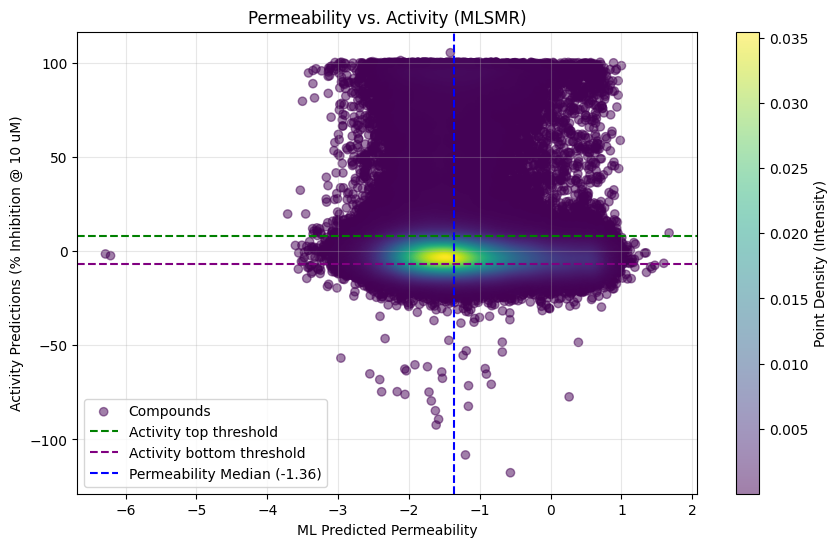

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Define thresholds
top_90_activity_threshold = top_activity_threshold
bottom_10_activity_threshold = bottom_activity_threshold

# Calculate density for intensity-based coloring
x = mlsmr_perm.values
y = mlsmr_activity.values
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Create the plot
plt.figure(figsize=(10, 6))

# Scatter plot of permeability vs. activity with intensity-based coloring
scatter = plt.scatter(mlsmr_perm, mlsmr_activity, c=z, cmap='viridis', alpha=0.5, label='Compounds')

# Add fixed threshold lines
plt.axhline(y=top_90_activity_threshold, color='green', linestyle='--', label=f'Activity top threshold' )#> {top_90_activity_threshold}')
plt.axhline(y=bottom_10_activity_threshold, color='purple', linestyle='--', label=f'Activity bottom threshold' )#≤ {bottom_10_activity_threshold}')
plt.axvline(x=perm_threshold, color='blue', linestyle='--', label=f'Permeability Median ({perm_threshold:.2f})')

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Point Density (Intensity)')

# Set axis labels and title
plt.xlabel('ML Predicted Permeability')
plt.ylabel('Activity Predictions (% Inhibition @ 10 uM)')
plt.title('Permeability vs. Activity (MLSMR)')
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()


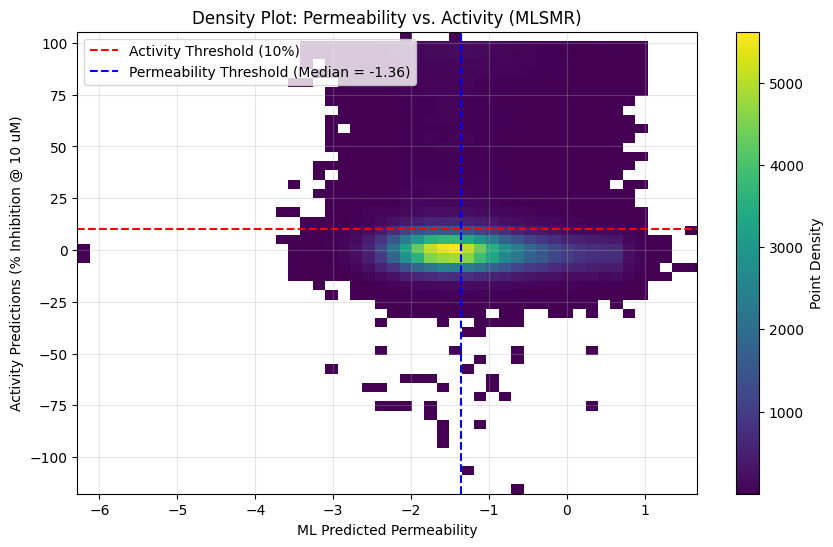

In [ ]:
plt.figure(figsize=(10, 6))
activity_threshold = 10
# 2D Histogram (Heatmap) for density
plt.hist2d(mlsmr_perm, mlsmr_activity, bins=50, cmap='viridis', cmin=1)

# Add color bar to indicate density
cbar = plt.colorbar()
cbar.set_label('Point Density')

# Add threshold lines
plt.axhline(y=activity_threshold, color='red', linestyle='--', label=f'Activity Threshold ({activity_threshold}%)')
plt.axvline(x=perm_threshold, color='blue', linestyle='--', label=f'Permeability Threshold (Median = {perm_threshold:.2f})')

# Set axis labels and title
plt.xlabel('ML Predicted Permeability')
plt.ylabel('Activity Predictions (% Inhibition @ 10 uM)')
plt.title('Density Plot: Permeability vs. Activity (MLSMR)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# AID (Enzyme) Dataset

In [ ]:
aid = pd.read_csv('AID_2606_datatable_all.csv').iloc[4::,:]
aid

aid_inhibition = aid.Inhibition
aid_smiles = aid.PUBCHEM_EXT_DATASOURCE_SMILES

# Load data
#enzyme_activity = enzyme['PUBCHEM_ACTIVITY_SCORE']
enzyme_activity = aid_inhibition
enzyme_smiles = aid_smiles
enzyme_perm = pd.read_csv('enzyme_perm_array.csv', header=None).squeeze()

# Drop NaNs from enzyme_activity and enzyme_smiles
valid_indices = enzyme_activity.notna() & enzyme_smiles.notna()  # Keep only valid rows

# Apply the same mask to both arrays
enzyme_activity = enzyme_activity[valid_indices].reset_index(drop=True)
enzyme_smiles = enzyme_smiles[valid_indices].reset_index(drop=True)

# Ensure enzyme_perm has the same length
enzyme_perm = enzyme_perm.iloc[:len(enzyme_activity)].reset_index(drop=True)

# Create DataFrame
enzyme_df = pd.DataFrame({'SMILES': enzyme_smiles,
                          'Activity': enzyme_activity,
                          'Permeability': enzyme_perm})

# Display DataFrame
enzyme_df

<ipython-input-14-eaaab98a4665>:1: DtypeWarning: Columns (0,8) have mixed types. Specify dtype option on import or set low_memory=False.
  aid = pd.read_csv('AID_2606_datatable_all.csv').iloc[4::,:]


SMILES Activity  \
0         COC1=CC(=NC(=N1)NC(=O)COC(=O)C2=CC(=CC=C2)Cl)OC   511.75   
1       CCN(CC)C1=CC2=C(C=C1)C(=C3C=CC(=[N+](CC)CC)C=C...   349.49   
2       CN1C2=CC=CC3=C2C(=C(C1=O)NCCC4=CC=CC=C4)C5=CC=...   206.82   
3       CCOC(=O)C1=CC=C(C=C1)NC(=O)C2=CN(N=C2C3=CC=NC=...   192.71   
4       CC\1(C2=CC=CC=C2N(/C1=C\C=C\C3=[N+](C4=C(C3(C)...   186.64   
...                                                   ...      ...   
324853  CC1(C2=C(C=CC(=C2)C(=O)OC)[N+](=C1/C=C/C3=C(C(...  -465.16   
324854  C1=CC(=CC=C1NC(=O)NC2=CC(=C(C=C2)OC(F)F)Cl)[N+...  -499.63   
324855  CC1=C(C2=C(C=C1)C(=C(O2)C(=O)NC3=CC=C(C=C3)S(=...  -516.55   
324856  CCN\1C2=CC=CC=C2S/C1=C\C(=C\C3=[N+](C4=CC=CC=C...  -611.28   
324857  CC\1(C2=CC=CC=C2N(/C1=C\C=C/3\C(=O)N(C(=S)S3)C...  -776.82   

        Permeability  
0          -0.272570  
1          -2.091539  
2          -2.178155  
3          -1.649340  
4          -1.285471  
...              ...  
324853     -1.538953  
324854     -1.687361  
324855     -1.714099  
324856     -1.483505  
324857      0.428944  

[324858 rows x 3 columns]

### thresholding experiments

In [ ]:
print(enzyme_df.head(5))


act = enzyme_df['Activity']
perm = enzyme_df['Permeability']

act = enzyme_df['Activity'] = pd.to_numeric(enzyme_df['Activity'], errors='coerce')
perm = enzyme_df['Permeability'] = pd.to_numeric(enzyme_df['Permeability'], errors='coerce')

# analysis
perm_threshold = perm.median()

# **Define Activity Bins**
# Activity ≥ 37.11 → High, Else → Low
filtered_taacf = enzyme_df.copy()
filtered_taacf['Activity Category'] = np.where(
    filtered_taacf['Activity'] >= 37.11, 'High Activity', 'Low Activity'
)

# **Define Permeability Bins**
# Use median permeability as the threshold
perm_threshold = perm.median()
filtered_taacf['Permeability Category'] = np.where(
    filtered_taacf['Permeability'] >= perm_threshold, 'High Permeability', 'Low Permeability'
)

# **Verify Counts**
num_high_activity = (filtered_taacf['Activity'] >= 37.11).sum()
num_low_activity = (filtered_taacf['Activity'] < 37.11).sum()
print(f"Number of High Activity points (≥37.11): {num_high_activity}")
print(f"Number of Low Activity points (<37.11): {num_low_activity}")

# **Create Contingency Table**
contingency_table = pd.crosstab(filtered_taacf['Permeability Category'], filtered_taacf['Activity Category'])

# **Perform Chi-Squared Test**
chi2, p, dof, expected = chi2_contingency(contingency_table)

# **Display Results**
print("\nContingency Table:")
print(contingency_table)

print("\nChi-Squared Test Results:")
print(f"Chi-Squared Statistic: {chi2:.4f}")
print(f"P-Value: {p:.10f}")
print(f"Degrees of Freedom: {dof}")

print("\nExpected Frequencies:")
print(expected)

                                              SMILES Activity  Permeability
0    COC1=CC(=NC(=N1)NC(=O)COC(=O)C2=CC(=CC=C2)Cl)OC   511.75     -0.272570
1  CCN(CC)C1=CC2=C(C=C1)C(=C3C=CC(=[N+](CC)CC)C=C...   349.49     -2.091539
2  CN1C2=CC=CC3=C2C(=C(C1=O)NCCC4=CC=CC=C4)C5=CC=...   206.82     -2.178155
3  CCOC(=O)C1=CC=C(C=C1)NC(=O)C2=CN(N=C2C3=CC=NC=...   192.71     -1.649340
4  CC\1(C2=CC=CC=C2N(/C1=C\C=C\C3=[N+](C4=C(C3(C)...   186.64     -1.285471
Number of High Activity points (≥37.11): 158
Number of Low Activity points (<37.11): 324700

Contingency Table:
Activity Category      High Activity  Low Activity
Permeability Category                             
High Permeability                 79        162350
Low Permeability                  79        162350

Chi-Squared Test Results:
Chi-Squared Statistic: 0.0000
P-Value: 1.0000000000
Degrees of Freedom: 1

Expected Frequencies:
[[7.9000e+01 1.6235e+05]
 [7.9000e+01 1.6235e+05]]


In [ ]:
# Define thresholds for high and low activity
high_activity_threshold = 8
low_activity_threshold = 2

# Select High Activity Group (Activity >= 8)
high_activity_df = enzyme_df[enzyme_df['Activity'] >= high_activity_threshold]

# Select Low Activity Group (Activity <= 0)
low_activity_df = enzyme_df[enzyme_df['Activity'] <= low_activity_threshold]

# Combine the dataset (No balancing required)
filtered_taacf = pd.concat([high_activity_df, low_activity_df])

# Define Activity Categories
filtered_taacf['Activity Category'] = np.where(
    filtered_taacf['Activity'] >= high_activity_threshold, 'High Activity', 'Low Activity'
)

# Define Permeability Bins using the median permeability as the threshold
perm_threshold = enzyme_df['Permeability'].median()
filtered_taacf['Permeability Category'] = np.where(
    filtered_taacf['Permeability'] <= perm_threshold, 'High Permeability', 'Low Permeability'
)

# Verify Counts
num_high_activity = (filtered_taacf['Activity'] >= high_activity_threshold).sum()
num_low_activity = (filtered_taacf['Activity'] <= low_activity_threshold).sum()
print(f"Number of High Activity points (≥{high_activity_threshold}): {num_high_activity}")
print(f"Number of Low Activity points (≤{low_activity_threshold}): {num_low_activity}")

# Create Contingency Table
contingency_table = pd.crosstab(filtered_taacf['Permeability Category'], filtered_taacf['Activity Category'])

# Perform Chi-Squared Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Display Results
print("\nContingency Table:")
print(contingency_table)

print("\nChi-Squared Test Results:")
print(f"Chi-Squared Statistic: {chi2:.4f}")
print(f"P-Value: {p:.10f}")
print(f"Degrees of Freedom: {dof}")

print("\nExpected Frequencies:")
print(expected)



Number of High Activity points (≥8): 19818
Number of Low Activity points (≤2): 223647

Contingency Table:
Activity Category      High Activity  Low Activity
Permeability Category                             
High Permeability               9864        112461
Low Permeability                9954        111186

Chi-Squared Test Results:
Chi-Squared Statistic: 1.8894
P-Value: 0.1692722238
Degrees of Freedom: 1

Expected Frequencies:
[[  9957.22937589 112367.77062411]
 [  9860.77062411 111279.22937589]]


In [ ]:
# Define threshold for high activity
activity_threshold = 37.42

# Select High Activity Group (Activity >= 37.42)
high_activity_df = enzyme_df[enzyme_df['Activity'] >= activity_threshold]

# Determine the number of high activity samples
num_high_activity = len(high_activity_df)

# Select Low Activity Group (Take the lowest values)
low_activity_df = enzyme_df[enzyme_df['Activity'] < activity_threshold].nsmallest(num_high_activity, 'Activity')

# Combine the balanced dataset
filtered_taacf = pd.concat([high_activity_df, low_activity_df])

# Define Activity Categories
filtered_taacf['Activity Category'] = np.where(
    filtered_taacf['Activity'] >= activity_threshold, 'High Activity', 'Low Activity'
)

# Define Permeability Bins using the median permeability as threshold
perm_threshold = enzyme_df['Permeability'].median()
filtered_taacf['Permeability Category'] = np.where(
    filtered_taacf['Permeability'] <= perm_threshold, 'High Permeability', 'Low Permeability'
)

# Verify Counts
num_high_activity = (filtered_taacf['Activity'] >= activity_threshold).sum()
num_low_activity = (filtered_taacf['Activity'] < activity_threshold).sum()
print(f"Number of High Activity points (≥{activity_threshold}): {num_high_activity}")
print(f"Number of Low Activity points (matching High count): {num_low_activity}")

# Create Contingency Table
contingency_table = pd.crosstab(filtered_taacf['Permeability Category'], filtered_taacf['Activity Category'])

# Perform Chi-Squared Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Display Results
print("\nContingency Table:")
print(contingency_table)

print("\nChi-Squared Test Results:")
print(f"Chi-Squared Statistic: {chi2:.4f}")
print(f"P-Value: {p:.10f}")
print(f"Degrees of Freedom: {dof}")

print("\nExpected Frequencies:")
print(expected)

Number of High Activity points (≥37.42): 157
Number of Low Activity points (matching High count): 157

Contingency Table:
Activity Category      High Activity  Low Activity
Permeability Category                             
High Permeability                 79            92
Low Permeability                  78            65

Chi-Squared Test Results:
Chi-Squared Statistic: 1.8491
P-Value: 0.1738883073
Degrees of Freedom: 1

Expected Frequencies:
[[85.5 85.5]
 [71.5 71.5]]


In [ ]:
# Getting the actual threshold value for Low Activity group
actual_low_activity_threshold = low_activity_df['Activity'].max()

# Verifying Counts and Report Threshold Value
num_high_activity = (filtered_taacf['Activity'] >= activity_threshold).sum()
num_low_activity = (filtered_taacf['Activity'] < activity_threshold).sum()

print(f"Number of High Activity points (≥{activity_threshold}): {num_high_activity}")
print(f"Number of Low Activity points (matching High count): {num_low_activity}")
print(f"Threshold Activity Value for Low Activity Group: {actual_low_activity_threshold:.4f}")

Number of High Activity points (≥37.42): 157
Number of Low Activity points (matching High count): 157
Threshold Activity Value for Low Activity Group: -205.9100


## top 1 percent and bottom 1 percent

In [ ]:
# Define the top 1% and bottom 1% thresholds
top_1_percentile = enzyme_df['Activity'].quantile(0.99)
bottom_1_percentile = enzyme_df['Activity'].quantile(0.01)

# Select High Activity Group (top 1%)
high_activity_df = enzyme_df[enzyme_df['Activity'] >= top_1_percentile]

# Select Low Activity Group (bottom 1%)
low_activity_df = enzyme_df[enzyme_df['Activity'] <= bottom_1_percentile]

# Combine the dataset
filtered_taacf = pd.concat([high_activity_df, low_activity_df])

# Define Activity Categories
filtered_taacf['Activity Category'] = np.where(
    filtered_taacf['Activity'] >= top_1_percentile, 'High Activity', 'Low Activity'
)

perm_threshold = enzyme_df['Permeability'].median()
filtered_taacf['Permeability Category'] = np.where(
    filtered_taacf['Permeability'] <= perm_threshold, 'High Permeability', 'Low Permeability'
)

# Verify Counts
num_high_activity = (filtered_taacf['Activity'] >= top_1_percentile).sum()
num_low_activity = (filtered_taacf['Activity'] <= bottom_1_percentile).sum()
print(f"Number of High Activity points (≥{top_1_percentile:.2f} - top 1%): {num_high_activity}")
print(f"Number of Low Activity points (≤{bottom_1_percentile:.2f} - bottom 1%): {num_low_activity}")

# Create Contingency Table
contingency_table_2 = pd.crosstab(filtered_taacf['Permeability Category'], filtered_taacf['Activity Category'])

# Perform Chi-Squared Test
chi2_2, p_2, dof_2, expected_2 = chi2_contingency(contingency_table_2)

# Display Results
print("\nContingency Table:")
print(contingency_table_2)

print("\nChi-Squared Test Results:")
print(f"Chi-Squared Statistic: {chi2_2:.4f}")
print(f"P-Value: {p_2:.10f}")
print(f"Degrees of Freedom: {dof_2}")

print("\nExpected Frequencies:")
print(expected_2)

Number of High Activity points (≥13.10 - top 2%): 3249
Number of Low Activity points (≤-45.24 - bottom 2%): 3250

Contingency Table:
Activity Category      High Activity  Low Activity
Permeability Category                             
High Permeability               1636          1747
Low Permeability                1613          1503

Chi-Squared Test Results:
Chi-Squared Statistic: 7.3895
P-Value: 0.0065607382
Degrees of Freedom: 1

Expected Frequencies:
[[1691.23972919 1691.76027081]
 [1557.76027081 1558.23972919]]


## top 2 percent and bottom 2 percent

In [ ]:
# Define the top 2% and bottom 2% thresholds
top_2_percentile = enzyme_df['Activity'].quantile(0.98)
bottom_2_percentile = enzyme_df['Activity'].quantile(0.02)

# Select High Activity Group (top 2%)
high_activity_df = enzyme_df[enzyme_df['Activity'] >= top_2_percentile]

# Select Low Activity Group (bottom 2%)
low_activity_df = enzyme_df[enzyme_df['Activity'] <= bottom_2_percentile]

# Combine the dataset
filtered_taacf = pd.concat([high_activity_df, low_activity_df])

# Define Activity Categories
filtered_taacf['Activity Category'] = np.where(
    filtered_taacf['Activity'] >= top_2_percentile, 'High Activity', 'Low Activity'
)

perm_threshold = enzyme_df['Permeability'].median()
filtered_taacf['Permeability Category'] = np.where(
    filtered_taacf['Permeability'] <= perm_threshold, 'High Permeability', 'Low Permeability'
)

# Verify Counts
num_high_activity = (filtered_taacf['Activity'] >= top_2_percentile).sum()
num_low_activity = (filtered_taacf['Activity'] <= bottom_2_percentile).sum()
print(f"Number of High Activity points (≥{top_2_percentile:.2f} - top 2%): {num_high_activity}")
print(f"Number of Low Activity points (≤{bottom_2_percentile:.2f} - bottom 2%): {num_low_activity}")

# Create Contingency Table
contingency_table_2 = pd.crosstab(filtered_taacf['Permeability Category'], filtered_taacf['Activity Category'])

# Perform Chi-Squared Test
chi2_2, p_2, dof_2, expected_2 = chi2_contingency(contingency_table_2)

# Display Results
print("\nContingency Table:")
print(contingency_table_2)

print("\nChi-Squared Test Results:")
print(f"Chi-Squared Statistic: {chi2_2:.4f}")
print(f"P-Value: {p_2:.10f}")
print(f"Degrees of Freedom: {dof_2}")

print("\nExpected Frequencies:")
print(expected_2)

Number of High Activity points (≥11.15 - top 2%): 6503
Number of Low Activity points (≤-26.30 - bottom 2%): 6498

Contingency Table:
Activity Category      High Activity  Low Activity
Permeability Category                             
High Permeability               3243          3444
Low Permeability                3260          3054

Chi-Squared Test Results:
Chi-Squared Statistic: 12.6357
P-Value: 0.0003784538
Degrees of Freedom: 1

Expected Frequencies:
[[3344.78586263 3342.21413737]
 [3158.21413737 3155.78586263]]


In [ ]:
import numpy as np
from scipy.stats import chi2_contingency

def cramers_v(chi2, n, dof):
    min_dof = max(dof, 1)  # Ensure dof is at least 1
    return np.sqrt(chi2 / (n * min_dof))

# Dataset 1
chi2_1, p_1, dof_1, expected_1 = chi2_contingency(contingency_table_1)
n_1 = np.sum(contingency_table_1.values)
cramer_v_1 = cramers_v(chi2_1, n_1, dof_1)

# Dataset 2
chi2_2, p_2, dof_2, expected_2 = chi2_contingency(contingency_table_2)
n_2 = np.sum(contingency_table_2.values)
cramer_v_2 = cramers_v(chi2_2, n_2, dof_2)

# Print results
print(f"Dataset 1: Chi-Squared = {chi2_1:.2f}, Cramér's V = {cramer_v_1:.4f}")
print(f"Dataset 2: Chi-Squared = {chi2_2:.2f}, Cramér's V = {cramer_v_2:.4f}")

# Compare
if cramer_v_1 > cramer_v_2:
    print("Dataset 1 has a stronger association.")
elif cramer_v_1 < cramer_v_2:
    print("Dataset 2 has a stronger association.")
else:
    print("Both datasets have the same association strength.")


Dataset 1: Chi-Squared = 501.61, Cramér's V = 0.0886
Dataset 2: Chi-Squared = 12.64, Cramér's V = 0.0312
Dataset 1 has a stronger association.


In [ ]:
## Sample code to make predictions for enzyme (see computation python script)
enzyme_smiles.iloc[0:4].to_csv('enzymes.csv')
arguments = [
    '--test_path', 'enzymes.csv',
    '--preds_path', 'content/enzyme_f.csv',
    '--checkpoint_dir', 'siegrist_mtb1600_test_checkpoints_reg',
    '--smiles_columns', 'SMILES',
    '--fingerprint_type', 'MPN'
]

args = chemprop.args.FingerprintArgs().parse_args(arguments)
preds = chemprop.train.molecule_fingerprint.molecule_fingerprint(args=args)

fingerprint = pd.read_csv('content/enzyme_f.csv')
print(fingerprint.head())
print(fingerprint.shape)

fingerprint_ = fingerprint.iloc[:,1::]
fingerprint_
mlp_optimal.predict(fingerprint_)

Loading training args


/usr/local/lib/python3.11/dist-packages/chemprop/utils.py:473: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vars(torch.load(path, map_location=lambda storage, loc: storage)

Setting molecule featurization parameters to default.
Loading data


4it [00:00, 19553.86it/s]
100%|██████████| 4/4 [00:00<00:00, 27822.91it/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validating SMILES
Test size = 4
Encoding smiles into a fingerprint vector from 1 models.


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/chemprop/utils.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, ma

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".



100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Saving predictions to content/enzyme_f.csv
Elapsed time = 0:00:02
                                              SMILES  fp_0_mol_0  fp_1_mol_0  \
0    COC1=CC(=NC(=N1)NC(=O)COC(=O)C2=CC(=CC=C2)Cl)OC    0.000000    0.034596   
1  CCN(CC)C1=CC2=C(C=C1)C(=C3C=CC(=[N+](CC)CC)C=C...    0.001607    0.025423   
2  CN1C2=CC=CC3=C2C(=C(C1=O)NCCC4=CC=CC=C4)C5=CC=...    0.000000    0.030046   
3  CCOC(=O)C1=CC=C(C=C1)NC(=O)C2=CN(N=C2C3=CC=NC=...    0.000000    0.009995   

   fp_2_mol_0  fp_3_mol_0  fp_4_mol_0  fp_5_mol_0  fp_6_mol_0  fp_7_mol_0  \
0    0.015489    0.054492    0.130906    0.365911    0.150214    0.214107   
1    0.017752    0.126314    0.090385    0.468295    0.239402    0.268542   
2    0.033444    0.187130    0.065030    0.554746    0.315712    0.387086   
3    0.030936    0.113298    0.074013    0.487038    0.278182    0.367351   

   fp_8_mol_0  ...  fp_290_mol_0  fp_291_mol_0  fp_292_mol_0  fp_293_mol_0  \
0         0.0  ...      0.047414      0.187080      0.377463      0.0

array([ 0.07731078, -2.25549329, -2.24805291, -1.36268863])

### Measuring overlap in datasets

In [ ]:
# Ensuring SMILES lists are converted to sets
taacf_smiles = set(taacf_smiles.dropna().astype(str))
mlsmr_smiles = set(mlsmr_smiles.dropna().astype(str))
enzyme_smiles = set(enzyme_smiles.dropna().astype(str))

overlap_taacf_mlsmr = len(taacf_smiles & mlsmr_smiles)
overlap_taacf_enzyme = len(taacf_smiles & enzyme_smiles)
overlap_mlsmr_enzyme = len(mlsmr_smiles & enzyme_smiles)

# Print results
print(f"Overlap between TAACF and MLSMR: {overlap_taacf_mlsmr} compounds")
print(f"Overlap between TAACF and Enzyme: {overlap_taacf_enzyme} compounds")
print(f"Overlap between MLSMR and Enzyme: {overlap_mlsmr_enzyme} compounds")

# Find compounds that are present in all three datasets
overlap_all = len(taacf_smiles & mlsmr_smiles & enzyme_smiles)
print(f"Compounds common to all three datasets: {overlap_all}")

Overlap between TAACF and MLSMR: 11515 compounds
Overlap between TAACF and Enzyme: 0 compounds
Overlap between MLSMR and Enzyme: 1356 compounds
Compounds common to all three datasets: 0


# 2. Machine learning modeling

## Data preparation

In [ ]:
siegrist = pd.read_excel('20240813_comprehensive_data(2).xlsx',
                         sheet_name = 'smiles_react_perm_380')
siegrist.head()

df_mtb_380 = pd.DataFrame({
    'Smiles': siegrist['Smile'],
    'MTB Standardized Residuals': siegrist['mtb_resid_std']
})

df_msm_380 = pd.DataFrame({
    'Smiles': siegrist['Smile'],
    'MSM Standardized Residuals': siegrist['msm_resid_std']
})
siegrist

df_mtb_380.dropna(axis=0, inplace=True)

# Filter invalid SMILES strings
valid_smiles = []
invalid_indices = []
for i, smile in enumerate(df_mtb_380['Smiles']):
    mol = Chem.MolFromSmiles(smile)
    if mol is not None:
        valid_smiles.append(smile)
    else:
        invalid_indices.append(i)

# Remove invalid entries from df
df_mtb_380 = df_mtb_380.drop(invalid_indices).reset_index(drop=True)

# Display the last 300 rows
print(df_mtb_380.shape)


y_mtb380 = df_mtb_380['MTB Standardized Residuals']

# 1200
siegrist = pd.read_excel('20240813_comprehensive_data(2).xlsx',
                         sheet_name = 'smiles_react_perm_1200')
siegrist.head()

df_mtb_1200 = pd.DataFrame({
    'Smiles': siegrist['Smile'],
    'MTB Standardized Residuals': siegrist['mtb_resid_std']
})

df_msm_1200 = pd.DataFrame({
    'Smiles': siegrist['Smile'],
    'MSM Standardized Residuals': siegrist['msm_resid_std']
})
siegrist

df_mtb_1200.dropna(axis=0, inplace=True)

# Filter invalid SMILES strings
valid_smiles = []
invalid_indices = []
for i, smile in enumerate(df_mtb_1200['Smiles']):
    mol = Chem.MolFromSmiles(smile)
    if mol is not None:
        valid_smiles.append(smile)
    else:
        invalid_indices.append(i)

# Remove invalid entries from df
df_mtb_1200 = df_mtb_1200.drop(invalid_indices).reset_index(drop=True)

# Display the last 300 rows
print(df_mtb_1200.shape)


y_mtb1200 = df_mtb_1200['MTB Standardized Residuals']


# 1519


df_mtb_1200, df_mtb_380

df_mtb_1519 = pd.concat([df_mtb_1200, df_mtb_380], axis=0)
df_mtb_1519

df_mtb_1519.dropna(axis=0, inplace=True)

# Filter invalid SMILES strings
valid_smiles = []
invalid_indices = []
for i, smile in enumerate(df_mtb_1519['Smiles']):
    mol = Chem.MolFromSmiles(smile)
    if mol is not None:
        valid_smiles.append(smile)
    else:
        invalid_indices.append(i)

# Display the last 300 rows
print(df_mtb_1519.shape)

y_mtb1519 = df_mtb_1519['MTB Standardized Residuals']



(376, 2)
(1143, 2)
(1519, 2)


### adding in the 40-dataset and training

In [ ]:
sieg_40 = pd.read_excel('20240813_comprehensive_data(2).xlsx',
                         sheet_name = 'smiles_react_perm_40')

sieg_40

df_mtb_40 = pd.DataFrame({
    'Smiles': sieg_40['Smile'],
    'MTB Standardized Residuals': sieg_40['mtb_resid_std']
})

df_mtb_1600  = pd.concat([df_mtb_1519, df_mtb_40], axis=0)
df_mtb_1600

df_mtb_1600.dropna(axis=0, inplace=True)



# Display the last 300 rows
print(df_mtb_1600.shape)

df_mtb_1600.dropna(axis=0, inplace=True)

# Filter invalid SMILES strings
valid_smiles = []
invalid_indices = []
for i, smile in enumerate(df_mtb_1600['Smiles']):
    mol = Chem.MolFromSmiles(smile)
    if mol is not None:
        valid_smiles.append(smile)
    else:
        invalid_indices.append(i)

# Remove invalid entries from df
df_mtb_1600 = df_mtb_1600.drop(invalid_indices).reset_index(drop=True)

# Display the last 300 rows
print(df_mtb_1600.shape)


y_mtb1600 = df_mtb_1600['MTB Standardized Residuals']

# Display the dataframe
print(df_mtb_1600)

df_mtb_1600.to_csv('siegrist_clean_mtb1600.csv')
arguments = [
    '--data_path', 'siegrist_clean_mtb1600.csv',
    '--dataset_type', 'regression',
    '--save_dir', 'siegrist_mtb1600_test_checkpoints_reg',
    '--ffn_hidden_size', '300',
    '--epochs', '30',
    '--save_smiles_splits',
    '--smiles_columns', 'Smiles',
    '--target_columns', 'MTB Standardized Residuals',
    '--split_type', 'scaffold_balanced',
    '--hidden_size', '300',
    '--metric', 'rmse',
    '--pytorch_seed', '0',
    '--seed', '0',
    '--num_folds', '1'

]

args = chemprop.args.TrainArgs().parse_args(arguments)
mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

arguments = [
    '--test_path', 'siegrist_clean_mtb1600.csv',
    '--preds_path', 'content/siegrist_excel_fingerprint_mtb1600.csv',
    '--checkpoint_dir', 'siegrist_mtb1600_test_checkpoints_reg',
    '--smiles_columns', 'Smiles',
    '--fingerprint_type', 'MPN'
]

args = chemprop.args.FingerprintArgs().parse_args(arguments)
preds = chemprop.train.molecule_fingerprint.molecule_fingerprint(args=args)

fingerprint = pd.read_csv('content/siegrist_excel_fingerprint_mtb1600.csv')
print(fingerprint.head())
print(fingerprint.shape)

fingerprint_ = fingerprint.iloc[:,1::]

index_bad = []
for idx, val in enumerate(fingerprint_.iloc[:, 1]):
    if val == 'Invalid SMILES':
        index_bad.append(idx)


y_mtb1600 = y_mtb1600.drop(index_bad).reset_index(drop=True)


X_mtb1600 = fingerprint_.drop(index_bad).reset_index(drop=True)
print(X_mtb1600)

(1558, 2)
(1558, 2)
                                                 Smiles  \
0            O=C1NC(CCC1(CC)C2=CC=C(N=[N+]=[N-])C=C2)=O   
1     OC([C@@H](NC(OC(C)(C)C)=O)CC1=CC=C(N=[N+]=[N-]...   
2     O[C@H]1[C@@H](CO)O[C@@H](OC2=CC=C(N=[N+]=[N-])...   
3                          COC1=CC(CCN=[N+]=[N-])=CC=C1   
4     C[C@@H](COC1=C2C(C3=O)=CC(F)=C1C4(N=[N+]=[N-])...   
...                                                 ...   
1553           COC(=O)C1=C(N=[N+]=[N-])N(C)C=2C=CC=CC12   
1554  CC(C)(C)OC(N[C@@H](CC1=CC=C(N=[N+]=[N-])C=C1)C...   
1555  CC=1C=CC=C2NC=C(C(=O)CN3CCC(CC3)C(=O)N[C@@H]4C...   
1556  OC(=O)C(CC1=CNC=2C=CC=CC12)NC(=O)[C@H]3C[C@@H]...   
1557  CC=1C=CC=2NC(=CC2C1C)C(=O)NC=3C=CC=C(CNC(=O)C=...   

      MTB Standardized Residuals  
0                      -0.419953  
1                       0.556694  
2                       0.364465  
3                       1.249244  
4                      -0.568972  
...                          ...  
1553                   -1.

Command line
python /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-7ede0eb8-209c-4851-9245-0303daab65f1.json
Args
{'activation': 'ReLU',
 'adding_bond_types': True,
 'adding_h': False,
 'aggregation': 'mean',
 'aggregation_norm': 100,
 'atom_constraints': [],
 'atom_descriptor_scaling': True,
 'atom_descriptors': None,
 'atom_descriptors_path': None,
 'atom_descriptors_size': 0,
 'atom_features_size': 0,
 'atom_messages': False,
 'atom_targets': [],
 'batch_size': 50,
 'bias': False,
 'bias_solvent': False,
 'bond_constraints': [],
 'bond_descriptor_scaling': True,
 'bond_descriptors': None,
 'bond_descriptors_path': None,
 'bond_descriptors_size': 0,
 'bond_features_size': 0,
 'bond_targets': [],
 'cache_cutoff': 10000,
 'checkpoint_dir': None,
 'checkpoint_frzn': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'class_balance': False,
 'config_path': None,
 'constraints_path': None,
 'crossval_index_dir': None,

Loading training args


/usr/local/lib/python3.11/dist-packages/chemprop/utils.py:473: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vars(torch.load(path, map_location=lambda storage, loc: storage)

Setting molecule featurization parameters to default.
Loading data


1558it [00:00, 135143.43it/s]
100%|██████████| 1558/1558 [00:00<00:00, 124644.28it/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validating SMILES
Test size = 1,558
Encoding smiles into a fingerprint vector from 1 models.


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/chemprop/utils.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, ma

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".



100%|██████████| 1/1 [00:08<00:00,  8.11s/it]


Saving predictions to content/siegrist_excel_fingerprint_mtb1600.csv
Elapsed time = 0:00:09
                                              Smiles  fp_0_mol_0  fp_1_mol_0  \
0         O=C1NC(CCC1(CC)C2=CC=C(N=[N+]=[N-])C=C2)=O    0.000000    0.068135   
1  OC([C@@H](NC(OC(C)(C)C)=O)CC1=CC=C(N=[N+]=[N-]...    0.000000    0.074706   
2  O[C@H]1[C@@H](CO)O[C@@H](OC2=CC=C(N=[N+]=[N-])...    0.000000    0.046933   
3                       COC1=CC(CCN=[N+]=[N-])=CC=C1    0.000000    0.082599   
4  C[C@@H](COC1=C2C(C3=O)=CC(F)=C1C4(N=[N+]=[N-])...    0.000275    0.041691   

   fp_2_mol_0  fp_3_mol_0  fp_4_mol_0  fp_5_mol_0  fp_6_mol_0  fp_7_mol_0  \
0    0.028792    0.026555    0.147642    0.348409    0.222728    0.129754   
1    0.022713    0.054514    0.101197    0.314463    0.145517    0.188333   
2    0.041304    0.122317    0.074848    0.156441    0.140499    0.252570   
3    0.047084    0.113486    0.044296    0.389773    0.228024    0.210274   
4    0.030334    0.082798    0.112785    0

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 1/400 - Train Loss: 0.9658 - Validation Loss: 1.2211


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 2/400 - Train Loss: 0.6054 - Validation Loss: 0.8029


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 3/400 - Train Loss: 0.5229 - Validation Loss: 0.6516


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 4/400 - Train Loss: 0.4120 - Validation Loss: 0.5340


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 5/400 - Train Loss: 0.3818 - Validation Loss: 0.4803


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 6/400 - Train Loss: 0.4504 - Validation Loss: 0.5856


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 7/400 - Train Loss: 0.3772 - Validation Loss: 0.4990


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 8/400 - Train Loss: 0.3516 - Validation Loss: 0.4559


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 9/400 - Train Loss: 0.3407 - Validation Loss: 0.4260


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 10/400 - Train Loss: 0.4036 - Validation Loss: 0.5394


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 11/400 - Train Loss: 0.3455 - Validation Loss: 0.4555


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 12/400 - Train Loss: 0.3356 - Validation Loss: 0.4378


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 13/400 - Train Loss: 0.3284 - Validation Loss: 0.4078


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 14/400 - Train Loss: 0.3844 - Validation Loss: 0.5189


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 15/400 - Train Loss: 0.3294 - Validation Loss: 0.4368


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 16/400 - Train Loss: 0.3216 - Validation Loss: 0.4177


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 17/400 - Train Loss: 0.3374 - Validation Loss: 0.4506


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 18/400 - Train Loss: 0.3125 - Validation Loss: 0.3988


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 19/400 - Train Loss: 0.3434 - Validation Loss: 0.4593


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 20/400 - Train Loss: 0.3080 - Validation Loss: 0.4043


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 21/400 - Train Loss: 0.3227 - Validation Loss: 0.3993


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 22/400 - Train Loss: 0.3150 - Validation Loss: 0.4282


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 23/400 - Train Loss: 0.3077 - Validation Loss: 0.3912


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 24/400 - Train Loss: 0.3196 - Validation Loss: 0.4377


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 25/400 - Train Loss: 0.3017 - Validation Loss: 0.3910


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 26/400 - Train Loss: 0.3538 - Validation Loss: 0.4807


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 27/400 - Train Loss: 0.3046 - Validation Loss: 0.4138


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 28/400 - Train Loss: 0.3055 - Validation Loss: 0.4017


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 29/400 - Train Loss: 0.3466 - Validation Loss: 0.4831


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 30/400 - Train Loss: 0.3000 - Validation Loss: 0.4086


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 31/400 - Train Loss: 0.3025 - Validation Loss: 0.3955


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 32/400 - Train Loss: 0.3207 - Validation Loss: 0.4495


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 33/400 - Train Loss: 0.2926 - Validation Loss: 0.3905


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 34/400 - Train Loss: 0.3488 - Validation Loss: 0.4942


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 35/400 - Train Loss: 0.2948 - Validation Loss: 0.4030


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 36/400 - Train Loss: 0.2958 - Validation Loss: 0.3964


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 37/400 - Train Loss: 0.3261 - Validation Loss: 0.4622


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 38/400 - Train Loss: 0.2869 - Validation Loss: 0.3936


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 39/400 - Train Loss: 0.3085 - Validation Loss: 0.3889


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 40/400 - Train Loss: 0.2899 - Validation Loss: 0.4041


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 41/400 - Train Loss: 0.2974 - Validation Loss: 0.3902


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 42/400 - Train Loss: 0.2925 - Validation Loss: 0.4146


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 43/400 - Train Loss: 0.2938 - Validation Loss: 0.3869


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 44/400 - Train Loss: 0.2918 - Validation Loss: 0.4143


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 45/400 - Train Loss: 0.2970 - Validation Loss: 0.3853


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 46/400 - Train Loss: 0.2827 - Validation Loss: 0.3953


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 47/400 - Train Loss: 0.3088 - Validation Loss: 0.4569
Epoch 48/400 - Train Loss: 0.2783 - Validation Loss: 0.3828


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 49/400 - Train Loss: 0.3016 - Validation Loss: 0.4405


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 50/400 - Train Loss: 0.2785 - Validation Loss: 0.3826


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 51/400 - Train Loss: 0.2832 - Validation Loss: 0.4053


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 52/400 - Train Loss: 0.2859 - Validation Loss: 0.3901


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 53/400 - Train Loss: 0.2833 - Validation Loss: 0.4133


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 54/400 - Train Loss: 0.2861 - Validation Loss: 0.3854


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 55/400 - Train Loss: 0.2755 - Validation Loss: 0.3971


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 56/400 - Train Loss: 0.2758 - Validation Loss: 0.3956


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 57/400 - Train Loss: 0.2948 - Validation Loss: 0.4399


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 58/400 - Train Loss: 0.2705 - Validation Loss: 0.3850


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 59/400 - Train Loss: 0.2933 - Validation Loss: 0.4371


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 60/400 - Train Loss: 0.2705 - Validation Loss: 0.3804


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 61/400 - Train Loss: 0.2735 - Validation Loss: 0.4004


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 62/400 - Train Loss: 0.3121 - Validation Loss: 0.4848


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 63/400 - Train Loss: 0.2653 - Validation Loss: 0.3926


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 64/400 - Train Loss: 0.2824 - Validation Loss: 0.4360


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 65/400 - Train Loss: 0.2716 - Validation Loss: 0.3975


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 66/400 - Train Loss: 0.2744 - Validation Loss: 0.4300


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 67/400 - Train Loss: 0.2680 - Validation Loss: 0.3897


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 68/400 - Train Loss: 0.2669 - Validation Loss: 0.4101


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 69/400 - Train Loss: 0.2714 - Validation Loss: 0.3957


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 70/400 - Train Loss: 0.2656 - Validation Loss: 0.4147
Early stopping at epoch 70
Optimal Epoch: 60
Validation Loss at Optimal Epoch: 0.3804


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(


Performance with Early Stopping:
Train Set MSE: 0.24552307696913897
Validation Set MSE: 0.3627050885930456
Test Set MSE: 0.29371011275095993
Train Set R2: 0.7446394552545534
Validation Set R2: 0.7106511568458553
Test Set R2: 0.7244501136244967


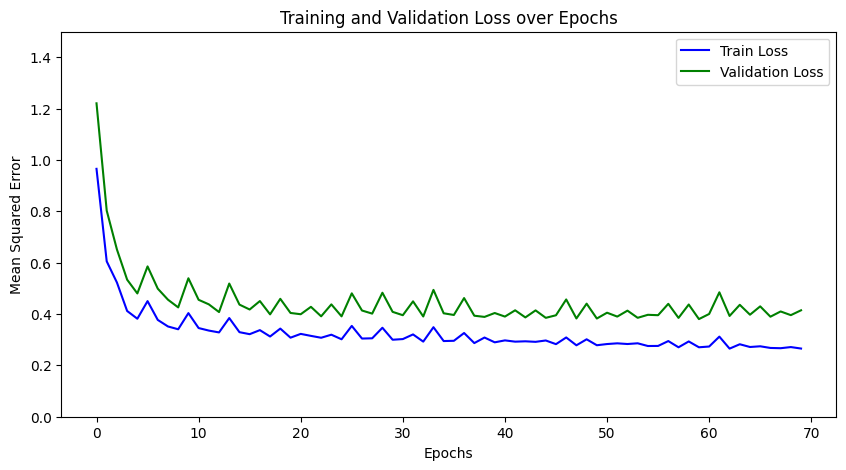

<ipython-input-25-9a3fa9194b1c>:78: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


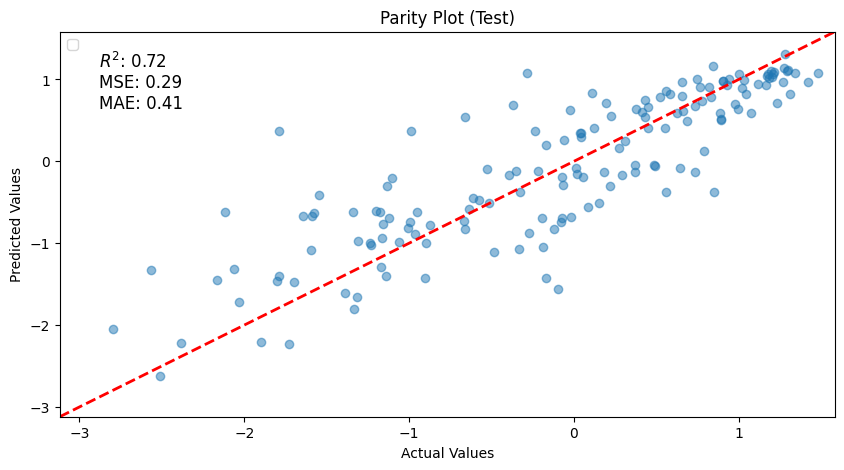

<ipython-input-25-9a3fa9194b1c>:92: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


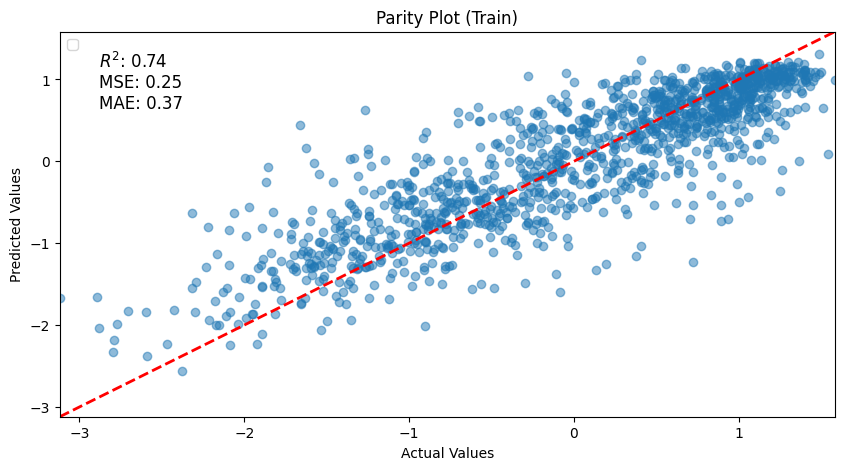

In [25]:
X_int, X_test, y_int, y_test = train_test_split(X_mtb1600, y_mtb1600, test_size=0.10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_int, y_int, test_size=0.10, random_state=42)

# Training the model with early stopping
_, train_losses, val_losses = train_mlp_with_early_stopping(X_train, X_val, y_train, y_val, epochs=400, patience=10)

optimal_epoch = np.argmin(val_losses)
optimal_val_loss = val_losses[optimal_epoch]

print(f"Optimal Epoch: {optimal_epoch+1}")
print(f"Validation Loss at Optimal Epoch: {optimal_val_loss:.4f}")

mlp_optimal = MLPRegressor(hidden_layer_sizes=(300, 200, 32,16), #
                              max_iter=optimal_epoch+1,
                              random_state=42,
                          alpha=0.01,
                        learning_rate='adaptive',
                      learning_rate_init = 0.001)

mlp_optimal.fit(X_train, y_train)
y_val_pred_optimal = mlp_optimal.predict(X_val)
y_test_pred_optimal = mlp_optimal.predict(X_test)

print("Performance with Early Stopping:")
print('Train Set MSE:', mean_squared_error(y_train, mlp_optimal.predict(X_train)))
print('Validation Set MSE:', mean_squared_error(y_val, y_val_pred_optimal))
print('Test Set MSE:', mean_squared_error(y_test, y_test_pred_optimal))

print('Train Set R2:', r2_score(y_train, mlp_optimal.predict(X_train)))
print('Validation Set R2:', r2_score(y_val, y_val_pred_optimal))
print('Test Set R2:', r2_score(y_test, y_test_pred_optimal))

# Plotting the trend of training and validation sets
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.ylim(0,1.5)
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()


# parity plot
train_mse = mean_squared_error(y_train, mlp_optimal.predict(X_train))
val_mse = mean_squared_error(y_val, y_val_pred_optimal)
test_mse = mean_squared_error(y_test, y_test_pred_optimal)

y_train_pred_optimal = mlp_optimal.predict(X_train)

train_r2 = r2_score(y_train, mlp_optimal.predict(X_train))
val_r2 = r2_score(y_val, y_val_pred_optimal)
test_r2 = r2_score(y_test, y_test_pred_optimal)

train_mae = mean_absolute_error(y_train, mlp_optimal.predict(X_train))
val_mae = mean_absolute_error(y_val, y_val_pred_optimal)
test_mae = mean_absolute_error(y_test, y_test_pred_optimal)

# Determine common scale limits
y_min = min(y_train.min(), y_test.min())
y_max = max(y_train.max(), y_test.max())

# Define padding for text
padding = (y_max - y_min) * 0.05

# Create a parity plot (Test)
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_test_pred_optimal, alpha=0.5)
plt.plot([y_min, y_max], [y_min, y_max], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.xlim(y_min, y_max)
plt.ylim(y_min, y_max)
plt.title('Parity Plot (Test)')
plt.text(y_min + padding, y_max - padding, f'$R^2$: {test_r2:.2f}\nMSE: {test_mse:.2f}\nMAE: {test_mae:.2f}',
         fontsize=12, verticalalignment='top')
plt.legend()
plt.show()

# Create a parity plot (Train)
plt.figure(figsize=(10, 5))
plt.scatter(y_train, y_train_pred_optimal, alpha=0.5)
plt.plot([y_min, y_max], [y_min, y_max], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.xlim(y_min, y_max)
plt.ylim(y_min, y_max)
plt.title('Parity Plot (Train)')
plt.text(y_min + padding, y_max - padding, f'$R^2$: {train_r2:.2f}\nMSE: {train_mse:.2f}\nMAE: {train_mae:.2f}',
         fontsize=12, verticalalignment='top')
plt.legend()
plt.show()

In [ ]:
from scipy.stats import spearmanr, kendalltau

# Computing the ranking correlations
spearman_train, _ = spearmanr(y_train, y_train_pred_optimal)
kendall_train, _ = kendalltau(y_train, y_train_pred_optimal)

spearman_test, _ = spearmanr(y_test, y_test_pred_optimal)
kendall_test, _ = kendalltau(y_test, y_test_pred_optimal)

# Correlation results
print("Ranking Correlation (Train Set):")
print(f"Spearman: {spearman_train:.4f}")
print(f"Kendall: {kendall_train:.4f}\n")

print("Ranking Correlation (Test Set):")
print(f"Spearman: {spearman_test:.4f}")
print(f"Kendall: {kendall_test:.4f}")

Ranking Correlation (Train Set):
Spearman: 0.8535
Kendall: 0.6653

Ranking Correlation (Test Set):
Spearman: 0.8645
Kendall: 0.6832


In [ ]:
train_x = (pd.DataFrame({'Actual':y_train,
              'Predicted': y_train_pred_optimal}))

test_x = (pd.DataFrame({'Actual':y_test,
              'Predicted': y_test_pred_optimal})  )

train_x.to_excel('Parity_plot_points_train.xlsx')
test_x.to_excel('Parity_plot_points_test.xlsx')

## Predictions for all the testing compounds

In [ ]:
def process_and_predict(file_path, sheet_names, preds_path, checkpoint_dir, smiles_column, fingerprint_type, model):
    datasets = {}

    for sheet in sheet_names:
        df = pd.read_excel(file_path, sheet_name=sheet)
        csv_name = f"{sheet}.csv"
        df.to_csv(csv_name, index=False)

        # Arguments definition for Chemprop
        arguments = [
            '--test_path', csv_name,
            '--preds_path', preds_path,
            '--checkpoint_dir', checkpoint_dir,
            '--smiles_columns', smiles_column,
            '--fingerprint_type', fingerprint_type
        ]

        args = chemprop.args.FingerprintArgs().parse_args(arguments)
        chemprop.train.molecule_fingerprint.molecule_fingerprint(args=args)

        # Load predictions
        preds_df = pd.read_csv(preds_path)

        # Append predictions to the dataset
        df['Prediction'] = model.predict(preds_df.iloc[:, 1::])
        datasets[sheet] = df

        # Saving each dataset as an Excel file
        df.to_excel(f"{sheet}_with_predictions.xlsx", index=False)

    return datasets

# Files call
file_path = '20250214 Last version of predictions for all figures in the paper.xlsx'
sheet_names = ['Fig S9(11)c', 'Fig S9(11)b', 'Fig S9(11)a', 'Fig 5a', 'Figure 4g (Kishors)', 'Fig4c (W peptides)']
preds_path = 'content/1600all_embeddings.csv'
checkpoint_dir = 'siegrist_mtb1600_test_checkpoints_reg'
smiles_column = 'SMILES'
fingerprint_type = 'MPN'

# predictions
datasets_with_preds = process_and_predict(file_path, sheet_names, preds_path, checkpoint_dir, smiles_column, fingerprint_type, mlp_optimal)


Loading training args


/usr/local/lib/python3.11/dist-packages/chemprop/utils.py:473: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vars(torch.load(path, map_location=lambda storage, loc: storage)

Setting molecule featurization parameters to default.
Loading data


24it [00:00, 4026.69it/s]
100%|██████████| 24/24 [00:00<00:00, 50131.12it/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validating SMILES
Test size = 24
Encoding smiles into a fingerprint vector from 1 models.


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/chemprop/utils.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, ma

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".



100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


Saving predictions to content/1600all_embeddings.csv
Elapsed time = 0:00:03
Loading training args


/usr/local/lib/python3.11/dist-packages/chemprop/utils.py:473: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vars(torch.load(path, map_location=lambda storage, loc: storage)

Setting molecule featurization parameters to default.
Loading data


8it [00:00, 38435.78it/s]
100%|██████████| 8/8 [00:00<00:00, 14671.81it/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validating SMILES
Test size = 8
Encoding smiles into a fingerprint vector from 1 models.


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/chemprop/utils.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, ma

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".



100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Saving predictions to content/1600all_embeddings.csv
Elapsed time = 0:00:03
Loading training args


/usr/local/lib/python3.11/dist-packages/chemprop/utils.py:473: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vars(torch.load(path, map_location=lambda storage, loc: storage)

Setting molecule featurization parameters to default.
Loading data


10it [00:00, 20530.12it/s]
100%|██████████| 10/10 [00:00<00:00, 15803.71it/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validating SMILES
Test size = 10
Encoding smiles into a fingerprint vector from 1 models.


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/chemprop/utils.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, ma

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".



100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Saving predictions to content/1600all_embeddings.csv
Elapsed time = 0:00:02
Loading training args


/usr/local/lib/python3.11/dist-packages/chemprop/utils.py:473: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vars(torch.load(path, map_location=lambda storage, loc: storage)

Setting molecule featurization parameters to default.
Loading data


101it [00:00, 49477.31it/s]
100%|██████████| 101/101 [00:00<00:00, 91475.86it/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validating SMILES
Test size = 101
Encoding smiles into a fingerprint vector from 1 models.


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/chemprop/utils.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, ma

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".



100%|██████████| 1/1 [00:04<00:00,  4.54s/it]


Saving predictions to content/1600all_embeddings.csv
Elapsed time = 0:00:05
Loading training args


/usr/local/lib/python3.11/dist-packages/chemprop/utils.py:473: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vars(torch.load(path, map_location=lambda storage, loc: storage)

Setting molecule featurization parameters to default.
Loading data


6it [00:00, 11826.05it/s]
100%|██████████| 6/6 [00:00<00:00, 32853.56it/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validating SMILES
Test size = 6
Encoding smiles into a fingerprint vector from 1 models.


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/chemprop/utils.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, ma

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".



100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Saving predictions to content/1600all_embeddings.csv
Elapsed time = 0:00:03
Loading training args


/usr/local/lib/python3.11/dist-packages/chemprop/utils.py:473: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vars(torch.load(path, map_location=lambda storage, loc: storage)

Setting molecule featurization parameters to default.
Loading data


3it [00:00, 16732.60it/s]
100%|██████████| 3/3 [00:00<00:00, 19909.67it/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validating SMILES
Test size = 3
Encoding smiles into a fingerprint vector from 1 models.


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/chemprop/utils.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, ma

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".



100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

Saving predictions to content/1600all_embeddings.csv
Elapsed time = 0:00:02


# 3. Interpretability analysis on hand-selected features

In [ ]:
# Importing pre-computed descriptors (see function calls above and relevant python script in GitHub)
descriptors = pd.read_csv('Hand_eng_descriptors.csv')
print(descriptors)

XGB score on train:  0.8435855182884153
XGB score on test:  0.8265326808421058


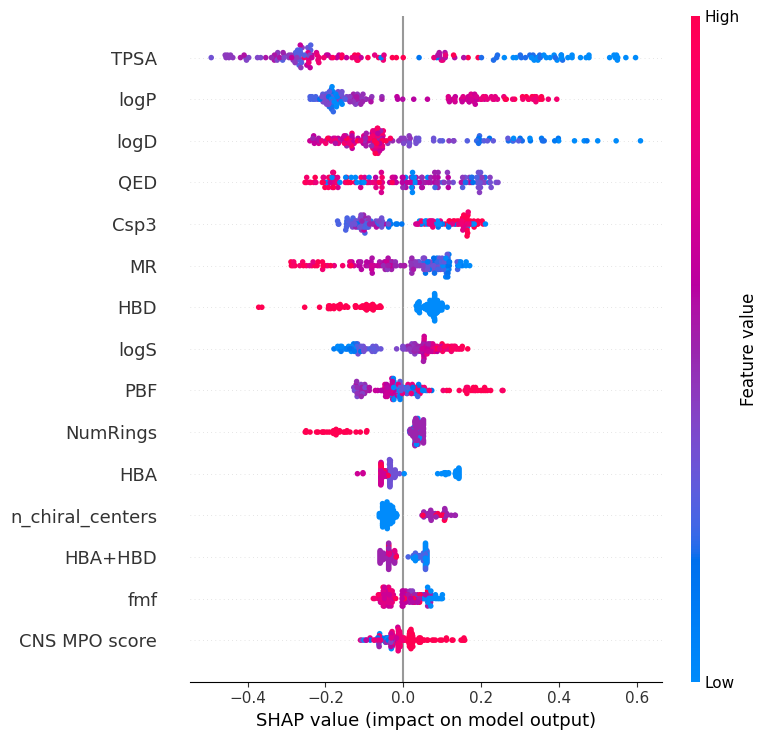

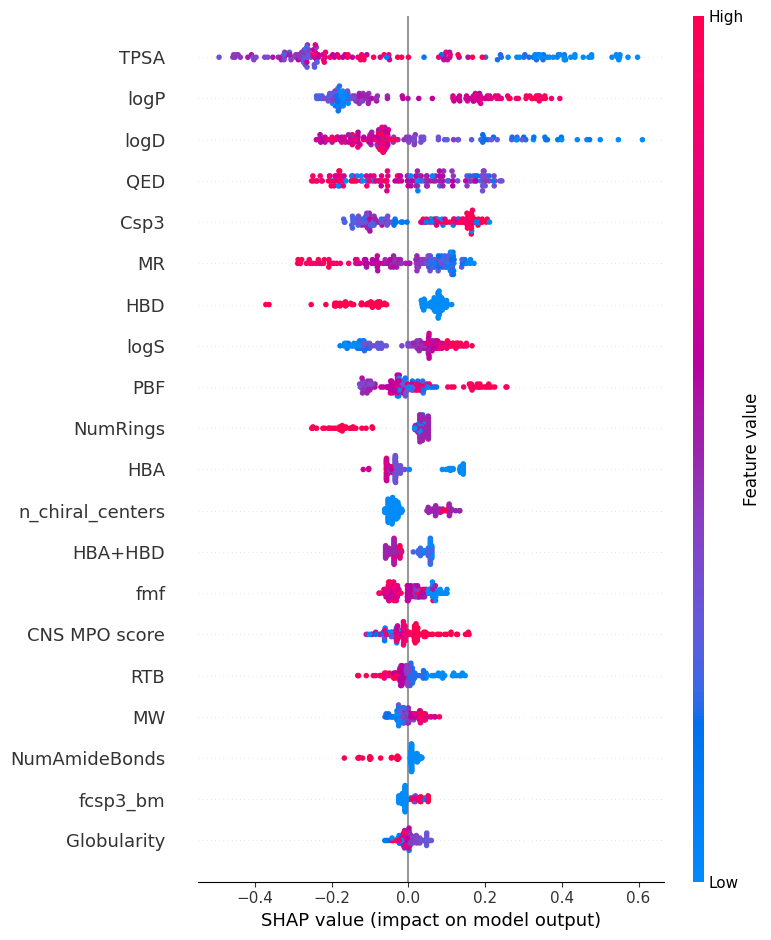

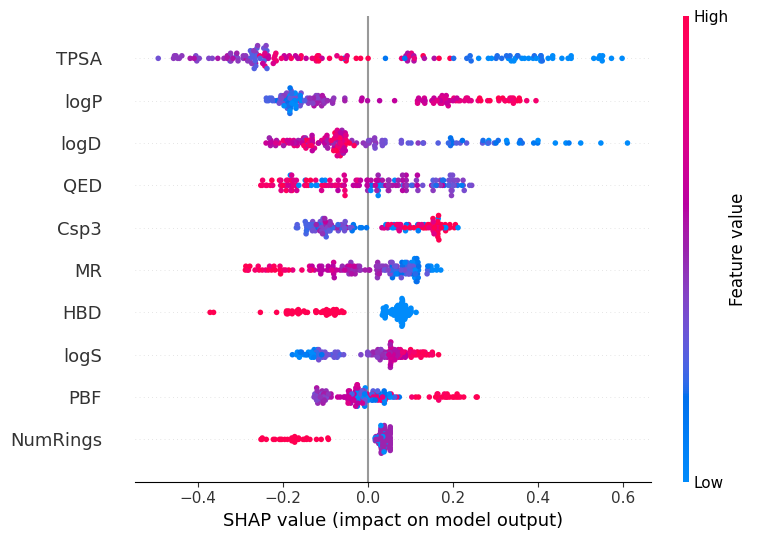

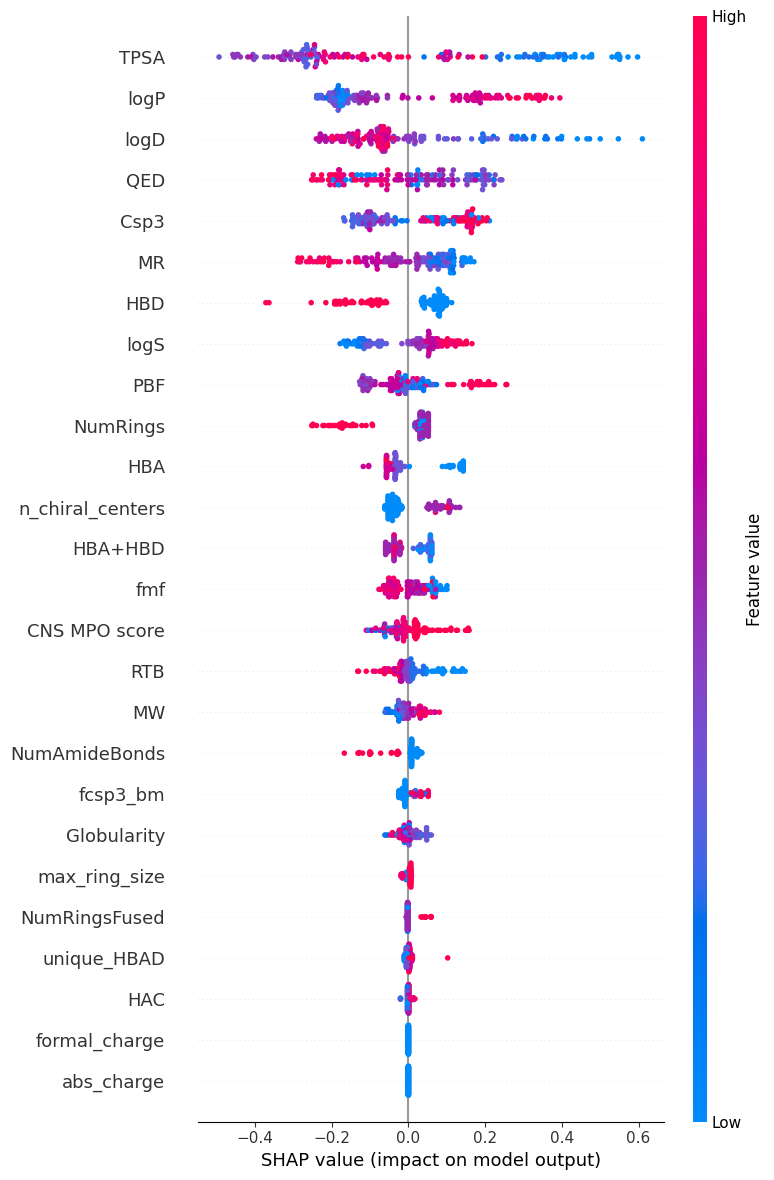

In [ ]:
# Validating that the indices are retained
X_train_indices = X_train.index
X_val_indices = X_val.index
X_test_indices = X_test.index

{
    "Train Indices": X_train_indices,
    "Validation Indices": X_val_indices,
    "Test Indices": X_test_indices,
}

# ------
X_train_desc = descriptors.loc[X_train_indices, descriptors.columns[1:]]
X_val_desc = descriptors.loc[X_val_indices, descriptors.columns[1:]]
X_test_desc = descriptors.loc[X_test_indices, descriptors.columns[1:]]

xgb_model_desc = xgboost.XGBRegressor(random_state=42, n_estimators=500,
                                      max_depth=3, reg_alpha=5)
xgb_model_desc.fit(X_train_desc, y_train_pred_optimal)

complex_ytrain = mlp_optimal.predict(X_train)
complex_ytest = mlp_optimal.predict(X_test)

print('XGB score on train: ', xgb_model_desc.score(X_train_desc, complex_ytrain))
print('XGB score on test: ',xgb_model_desc.score(X_test_desc,complex_ytest))

explainer_desc = shap.Explainer(xgb_model_desc, X_test_desc)
shap_values = explainer_desc(X_test_desc)

# Visualizations
shap.summary_plot(shap_values, X_test_desc, max_display=15)
shap.summary_plot(shap_values, X_test_desc, max_display=20)
shap.summary_plot(shap_values, X_test_desc, max_display=10)
shap.summary_plot(shap_values, X_test_desc, max_display=30)


In [ ]:
smiles_for_X_test = pd.read_excel('20240813_comprehensive_data(2).xlsx', sheet_name= '01_16_2025')['SMILES']
test = calc_descriptors(smiles_for_X_test)
test_names = pd.read_excel('20240813_comprehensive_data(2).xlsx', sheet_name= '01_16_2025')['NAMES']
test['logD'] = pd.read_excel('20240813_comprehensive_data(2).xlsx', sheet_name= '01_16_2025')['Log D (CDD calculated)']
test['logS'] = pd.read_excel('20240813_comprehensive_data(2).xlsx', sheet_name= '01_16_2025')['Log S (CDD calculated)']
test['CNS MPO score'] = pd.read_excel('20240813_comprehensive_data(2).xlsx', sheet_name= '01_16_2025')['CNS MPO score (CDD calculated)']

0


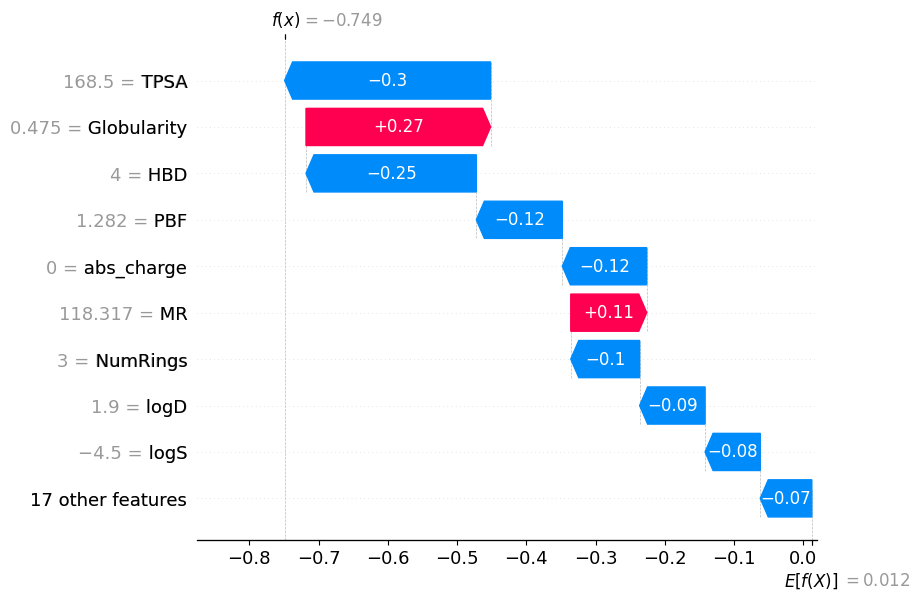

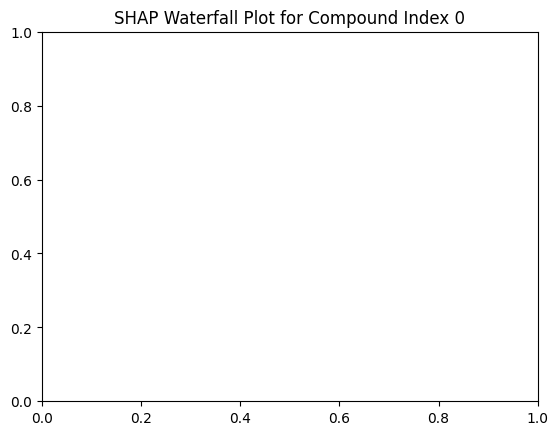

1


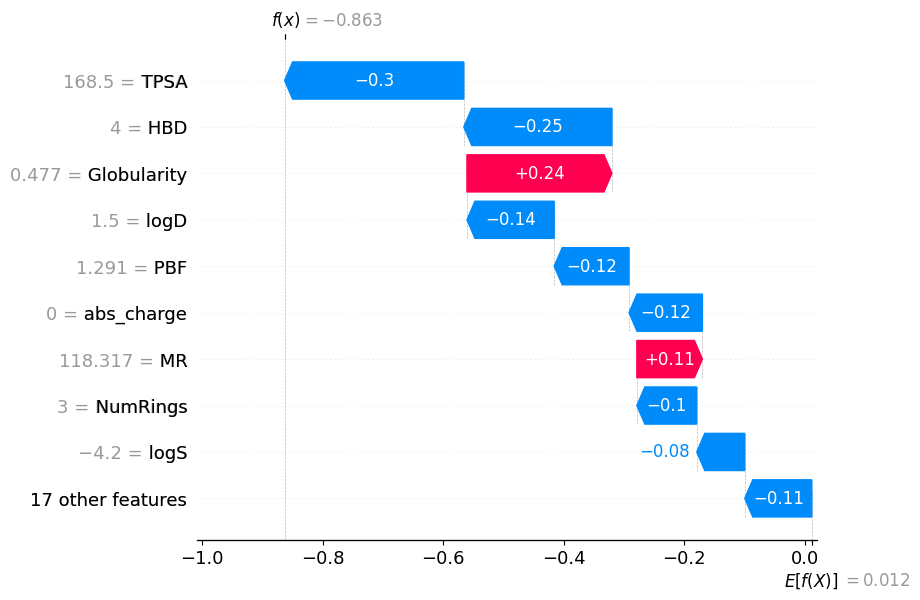

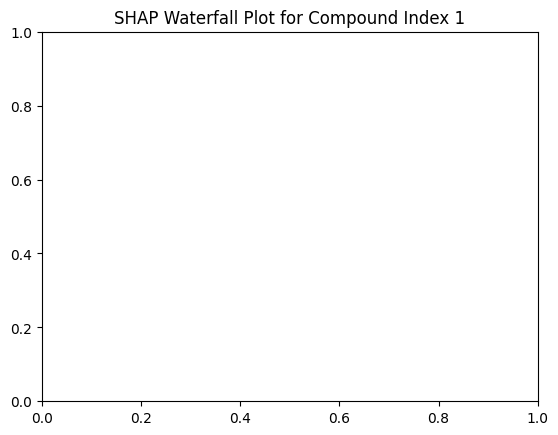

2


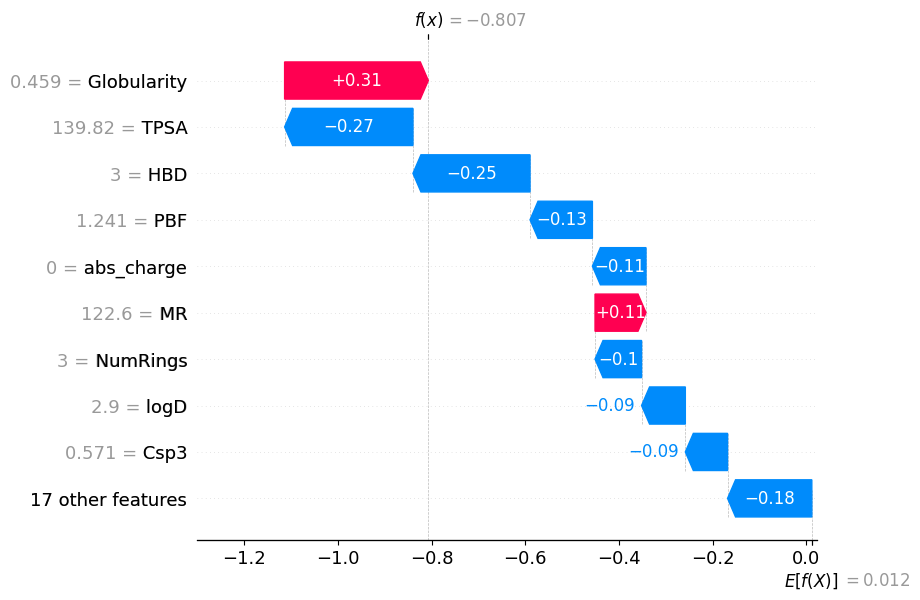

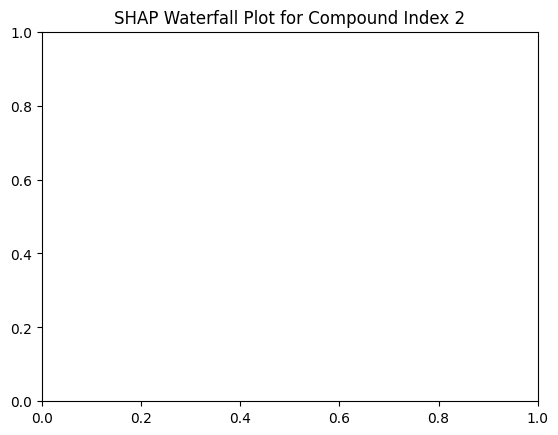

3


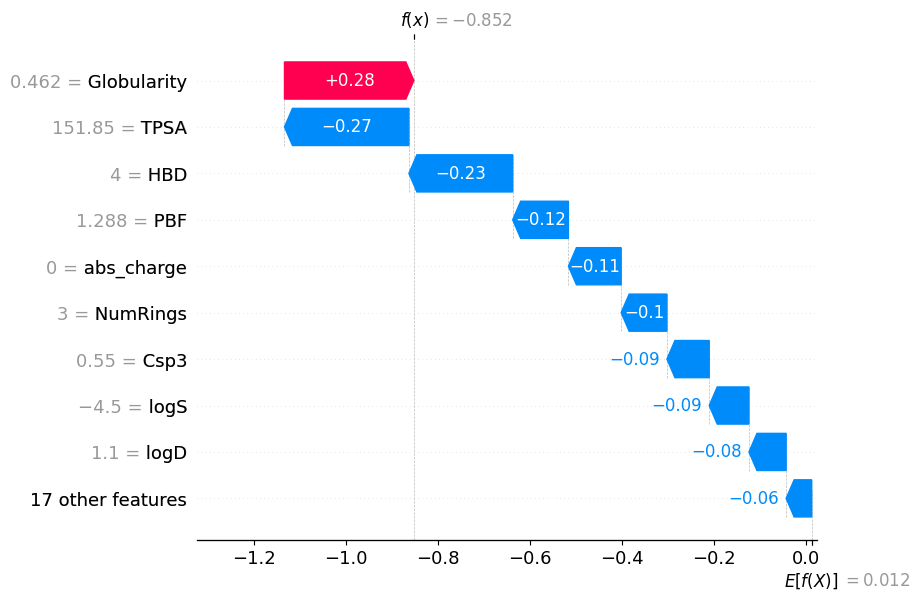

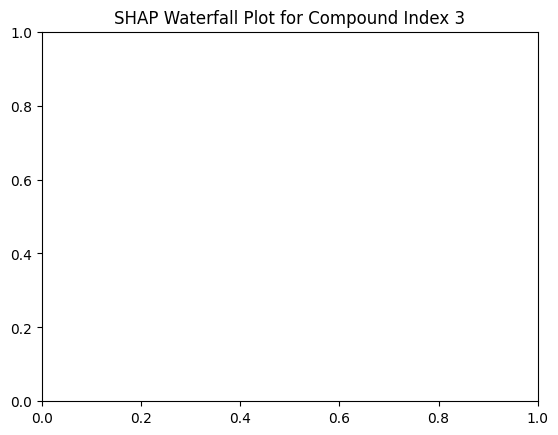

4


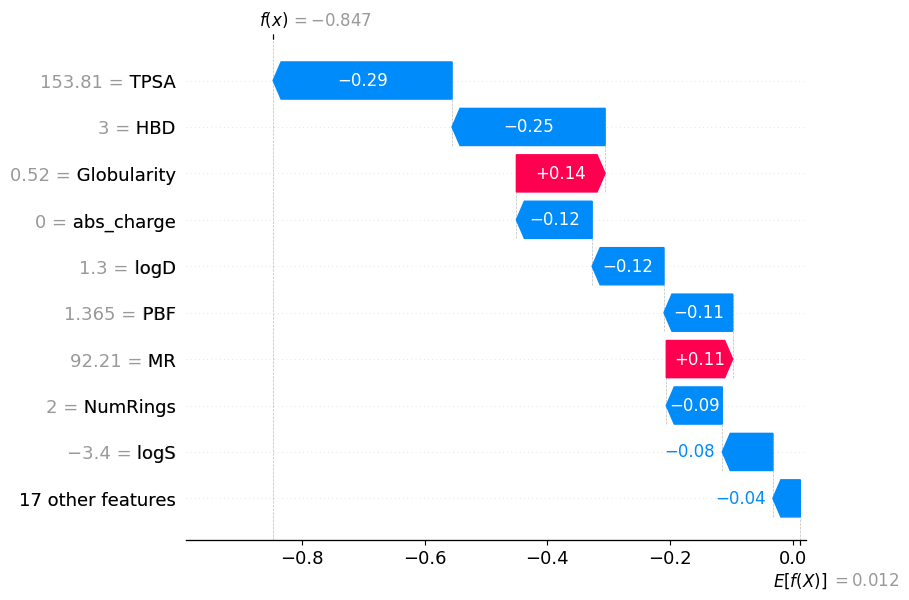

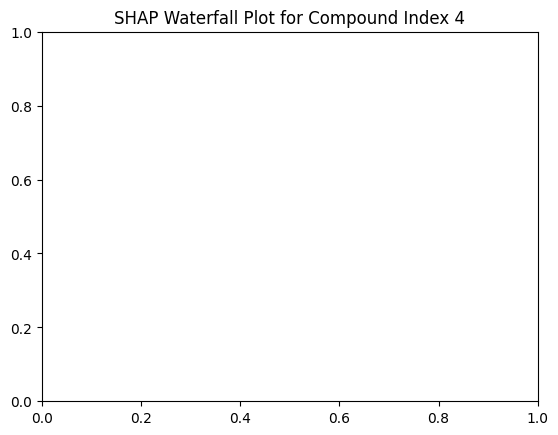

5


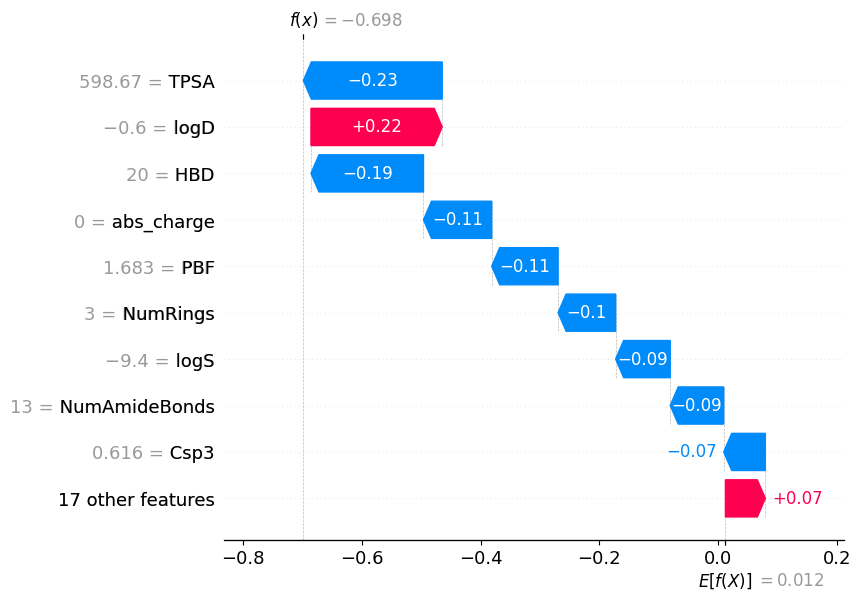

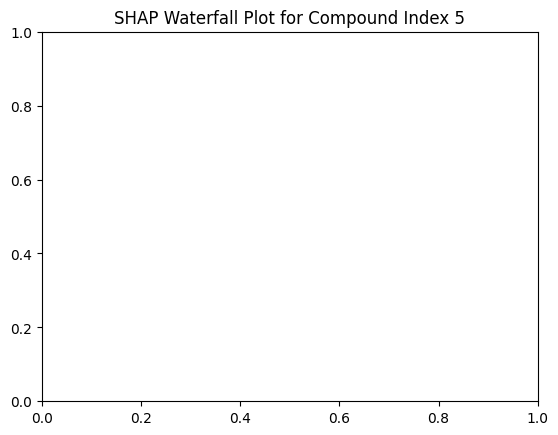

6


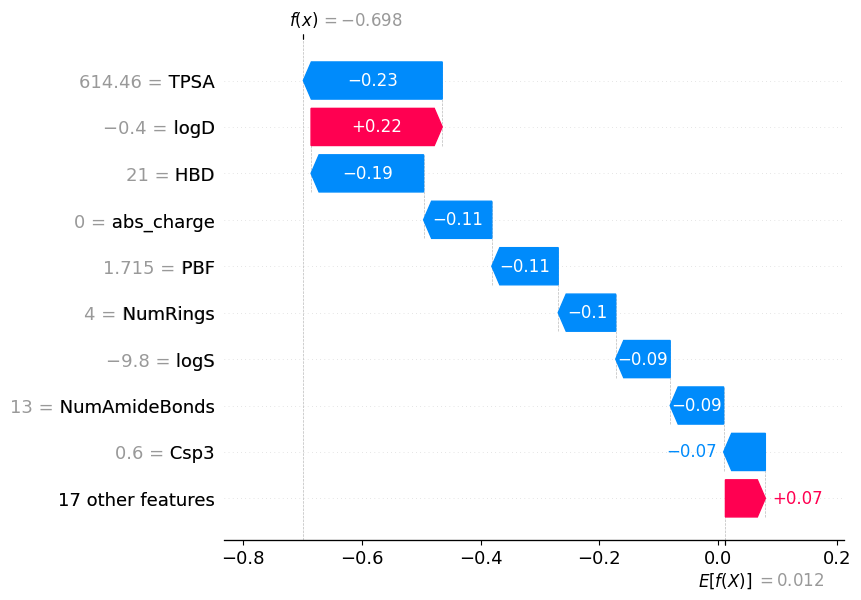

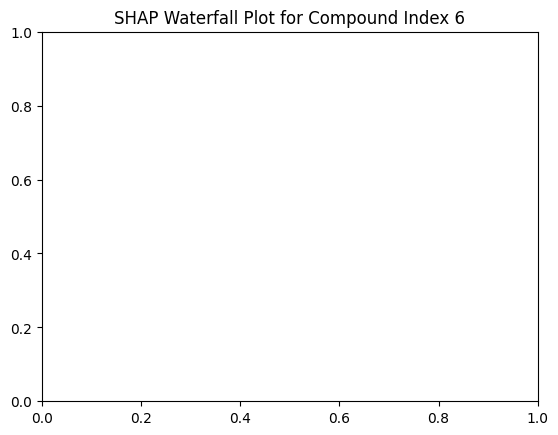

7


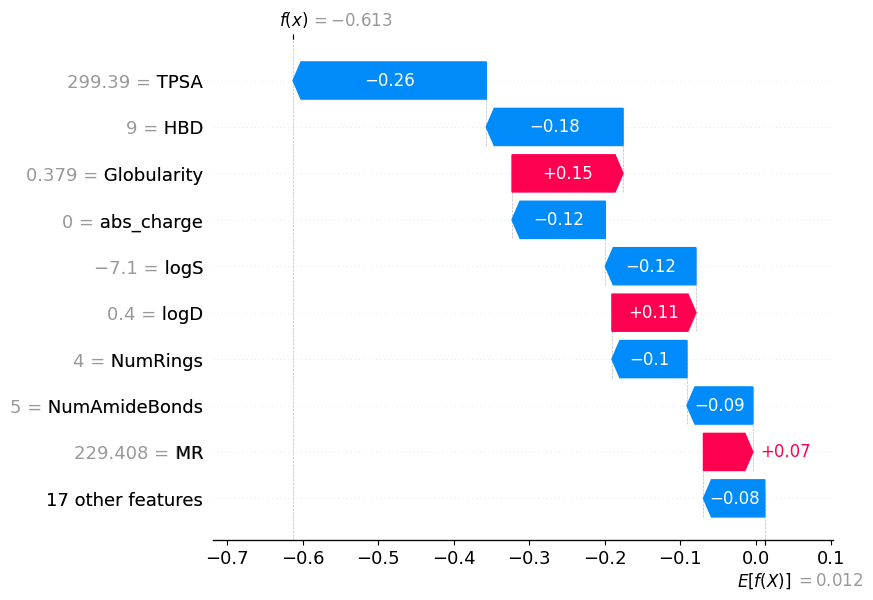

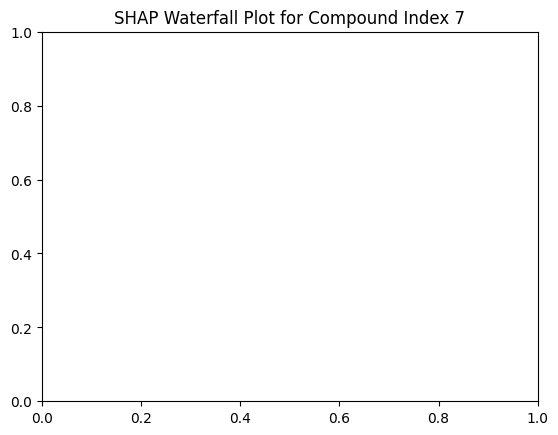

8


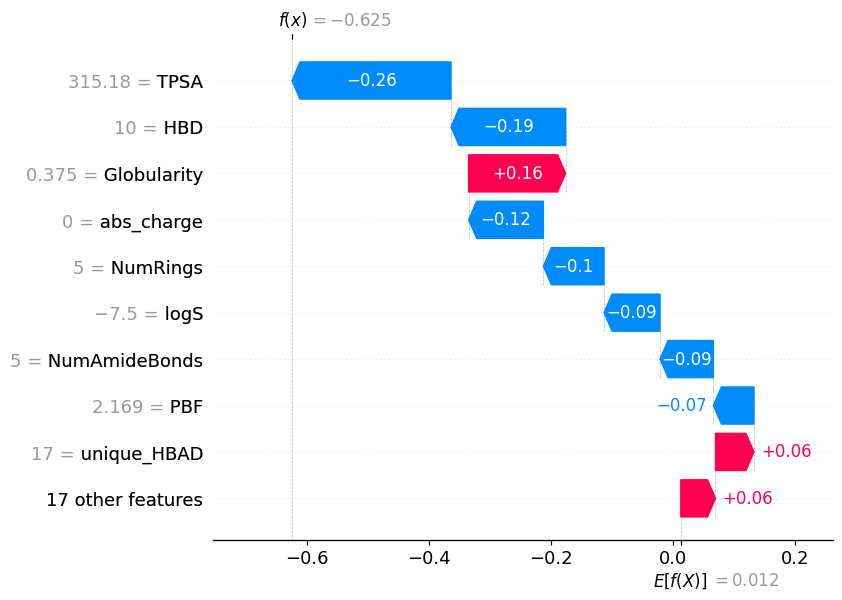

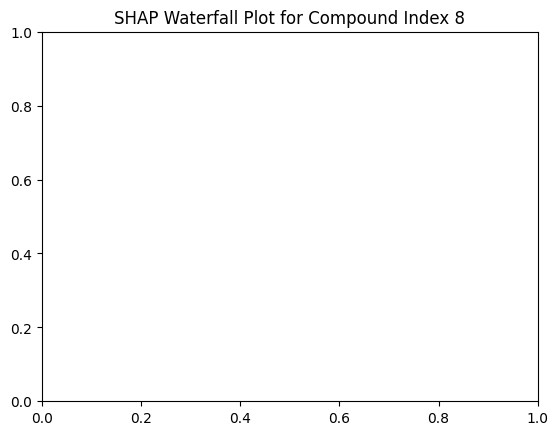

9


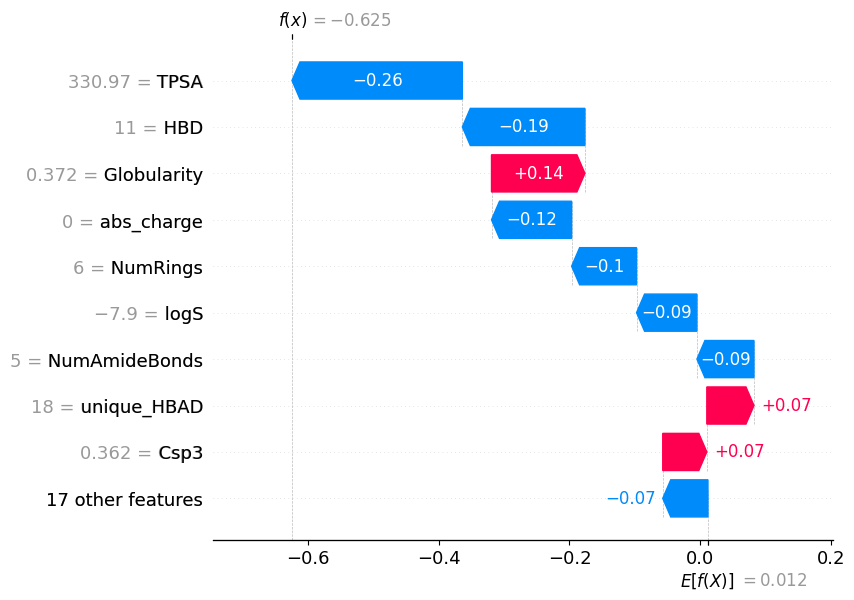

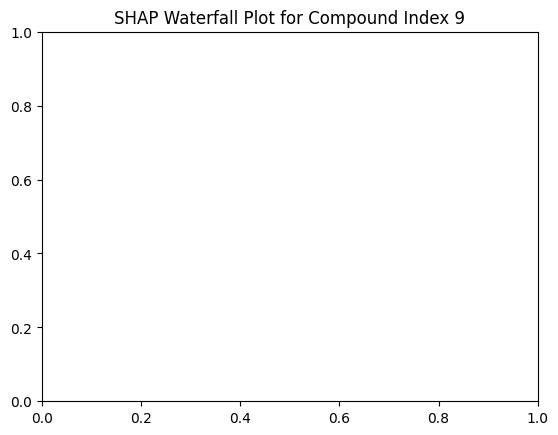

In [ ]:
for index in range(len(test)):
    print(index)
    compound_to_explain = test.iloc[[index]]  # Select the compound to explain
    shap_values_compound = explainer_desc(compound_to_explain)  # Compute SHAP values

    # SHAP waterfall plot of individual compounds
    shap.waterfall_plot(shap_values_compound[0], max_display = 10)
    plt.title(f"SHAP Waterfall Plot for Compound Index {index}")
    plt.show()

# 4. Chemical Space Visualization

## Chemical space for inhouse library

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


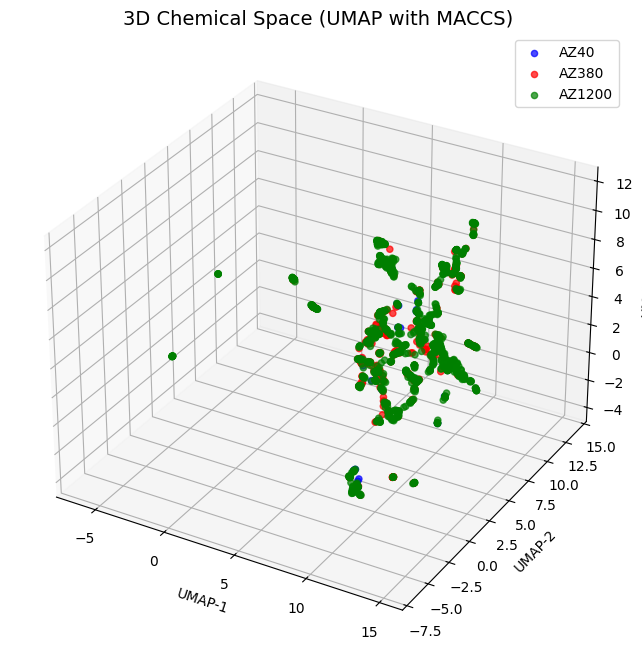

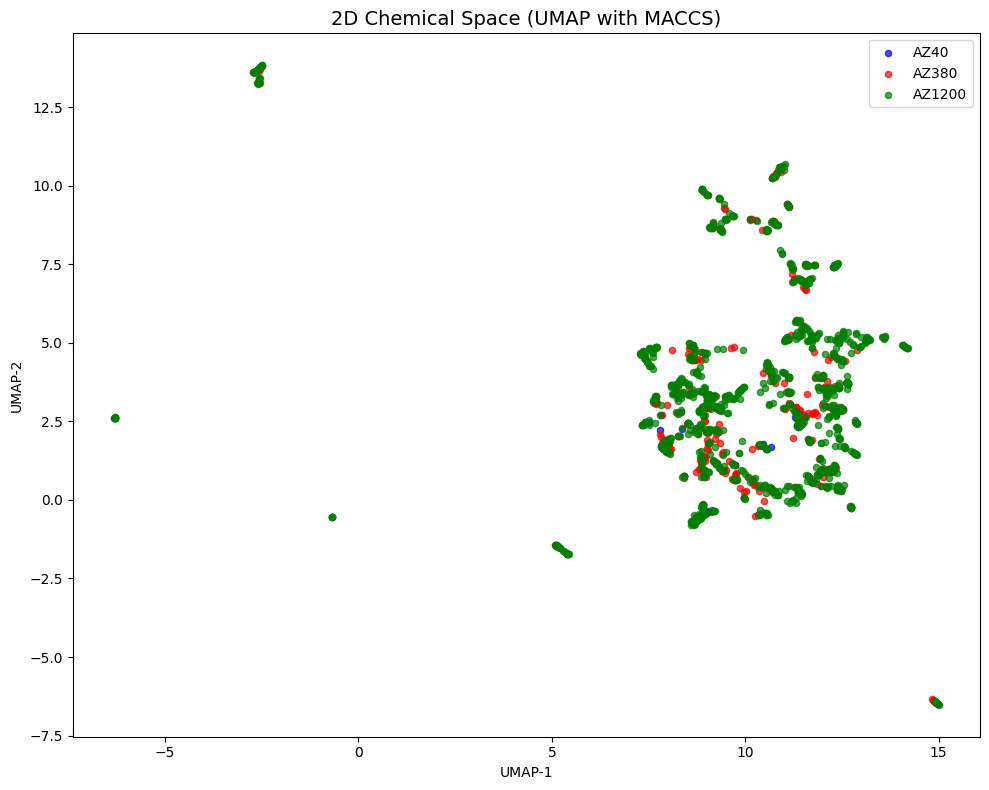

In [ ]:
az40 = pd.read_excel('20240813_comprehensive_data(2).xlsx', sheet_name = 'smiles_react_perm_40')
az380 = pd.read_excel('20240813_comprehensive_data(2).xlsx', sheet_name = 'smiles_react_perm_380')
az1200 = pd.read_excel('20240813_comprehensive_data(2).xlsx', sheet_name = 'smiles_react_perm_1200')

# Combining datasets and their labels
az40['Dataset'] = 'AZ40'
az380['Dataset'] = 'AZ380'
az1200['Dataset'] = 'AZ1200'
combined_data = pd.concat([az40, az380, az1200], ignore_index=True)

# MACCS Generation
def smiles_to_maccs(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return list(MACCSkeys.GenMACCSKeys(mol))
    else:
        return [0] * 167  # MACCS keys have 167 bits

combined_data['MACCS'] = combined_data['Smile'].apply(smiles_to_maccs)

# Preparing MACCS keys for UMAP
maccs_features = pd.DataFrame(combined_data['MACCS'].tolist(), index=combined_data.index)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(maccs_features)

# 3D Embedding Generation
umap_3d = umap.UMAP(n_components=3, random_state=42)
embedding_3d = umap_3d.fit_transform(scaled_features)

# Adding the UMAP coordinates to the dataframe
combined_data['UMAP-1'] = embedding_3d[:, 0]
combined_data['UMAP-2'] = embedding_3d[:, 1]
combined_data['UMAP-3'] = embedding_3d[:, 2]

# Plotting the 3D chemical space
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Defining colors for each dataset
for dataset, color in zip(['AZ40', 'AZ380', 'AZ1200'], ['blue', 'red', 'green']):
    subset = combined_data[combined_data['Dataset'] == dataset]
    ax.scatter(
        subset['UMAP-1'], subset['UMAP-2'], subset['UMAP-3'],
        label=dataset, alpha=0.7, s=20, color=color
    )

# Adding plot titles and labels
ax.set_title('3D Chemical Space (UMAP with MACCS)', fontsize=14)
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_zlabel('UMAP-3')
ax.legend()
plt.show()

# Plotting the 2D chemical space
plt.figure(figsize=(10, 8))

# Defining colors for each dataset
for dataset, color in zip(['AZ40', 'AZ380', 'AZ1200'], ['blue', 'red', 'green']):
    subset = combined_data[combined_data['Dataset'] == dataset]
    plt.scatter(
        subset['UMAP-1'], subset['UMAP-2'],
        label=dataset, alpha=0.7, s=20, color=color
    )

# Adding plot titles and labels
plt.title('2D Chemical Space (UMAP with MACCS)', fontsize=14)
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.legend()
#plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()



In [ ]:
# an interactive 3D plot using Plotly
fig = px.scatter_3d(
    combined_data,
    x='UMAP-1',
    y='UMAP-2',
    z='UMAP-3',
    color='Dataset',
    title='3D Chemical Space (UMAP with MACCS)',
    labels={'UMAP-1': 'UMAP-1', 'UMAP-2': 'UMAP-2', 'UMAP-3': 'UMAP-3'},
    opacity=0.7,
    color_discrete_map={
        'AZ40': 'green',
        'AZ380': 'red',
        'AZ1200': 'blue'
    }
)
fig.update_traces(marker=dict(size=4))
fig.show()

# Overlap studies

In [ ]:
smiles_380 = pd.read_excel('20240813_comprehensive_data(2).xlsx', sheet_name = 'smiles_react_perm_40').Smile


pd.read_excel('20240813_comprehensive_data(2).xlsx', sheet_name = 'smiles_react_perm_40')


Smile  logReact  mtb_perm  \
0                                     NCCCN=[N+]=[N-] -0.667436  0.654736   
1                O=C(O)[C@@H]1C[C@@H](N=[N+]=[N-])CN1 -0.034547  0.866489   
2                               [N-]=[N+]=NCCN1CCOCC1 -0.558633  0.694329   
3                      N[C@@H](CCCCN=[N+]=[N-])C(O)=O -0.192001  0.646477   
4                    COC1=CC=C(C(CN=[N+]=[N-])=O)C=C1 -1.221645  0.337237   
5                                OCCOCCOCCN=[N+]=[N-] -0.454829  0.741684   
6           OC([C@@H](CN=[N+]=[N-])NC(OC(C)(C)C)=O)=O -0.100740  0.797988   
7                               OC(CCCCN=[N+]=[N-])=O -0.216748  0.808998   
8              O=C(OC(C)(C)C)N1CCC[C@@H]1CN=[N+]=[N-] -1.376351  0.420857   
9              OC([C@@H]1CC[C@@H](CN=[N+]=[N-])CC1)=O -0.266192  0.721743   
10                            [N-]=[N+]=NCC1=CC=CN=C1 -1.216529  0.308662   
11                            OCCOCCOCCOCCN=[N+]=[N-] -0.437365  0.771317   
12  O=C(N1[C@H](C(O)=O)C[C@H](N=[N+]=[N-])C1)OCC2C... -0.544069  0.848277   
13        OC([C@H](CCCCNC(OC(C)(C)C)=O)N=[N+]=[N-])=O -0.107024  0.828632   
14  O=C(N1)N([C@@H]2O[C@H](CO)[C@@H](N=[N+]=[N-])C... -0.455829  0.765949   
15                             CCOC(CCCN=[N+]=[N-])=O -1.227983  0.437531   
16                                   NCCCCN=[N+]=[N-] -1.140549  0.340501   
17                        OC([C@@H](CN=[N+]=[N-])N)=O -0.046699  0.602348   
18                               NCCOCCOCCN=[N+]=[N-] -1.023661  0.441849   
19  OC([C@H](CCCCN=[N+]=[N-])NC(OCC1C(C=CC=C2)=C2C... -1.345477  0.090734   
20              O=C(OC(C)(C)C)N1CCC[C@H]1CN=[N+]=[N-] -1.419973  0.285498   
21                        COC1=CC=C(CN=[N+]=[N-])C=C1 -1.438277  0.287650   
22                     [N-]=[N+]=NCCC1=CNC2=C1C=CC=C2 -2.181983  0.137786   
23                                OC(CCN=[N+]=[N-])=O -0.055798  0.768541   
24                                 OCC(O)CN=[N+]=[N-] -0.216323  0.671901   
25  O=C(NC1=O)C(CN=[N+]=[N-])=CN1[C@@H]2O[C@H](CO)... -1.236538  0.717304   
26  CC(O[C@@H]1[C@@H](COC(C)=O)O[C@@H](N=[N+]=[N-]... -0.336423  0.714886   
27                                 OC(CN=[N+]=[N-])=O -0.068856  0.784017   
28                CC=1NC=2C=CC=CC2C1C(=O)CN=[N+]=[N-] -2.089193  0.119008   
29                            [N-]=[N+]=NCC1=CC=CC=C1 -1.596485  0.620122   
30                    CC1=CC=2C=C(N=[N+]=[N-])C=CC2N1 -1.757100  0.225262   
31   OC[C@H]1OC(O)[C@H](N=[N+]=[N-])[C@@H](O)[C@@H]1O -0.078510  0.927997   
32  OC[C@H]1O[C@H](O[C@@H]2[C@H](O)[C@@H](O)[C@H](...  0.000000  0.886979   
33  OC=1C=CC=2NC(=CC2C1)C(=O)N(CCN=[N+]=[N-])CC=3C... -2.184866  0.013450   
34           COC(=O)C1=C(N=[N+]=[N-])N(C)C=2C=CC=CC12 -1.884867  0.391472   
35  CC(C)(C)OC(N[C@@H](CC1=CC=C(N=[N+]=[N-])C=C1)C... -0.276211  0.827431   
36  CC=1C=CC=C2NC=C(C(=O)CN3CCC(CC3)C(=O)N[C@@H]4C... -1.774349  0.030432   
37  OC(=O)C(CC1=CNC=2C=CC=CC12)NC(=O)[C@H]3C[C@@H]... -0.545833  0.796057   
38  CC=1C=CC=2NC(=CC2C1C)C(=O)NC=3C=CC=C(CNC(=O)C=... -1.628907  0.837874   

    msm_perm  mtb_resid_std  msm_resid_std  
0   0.381394       0.313865      -0.272607  
1   0.975630       1.189057       1.332710  
2   0.640795       0.471585       0.338066  
3   0.663209       0.590406       0.583009  
4   0.257011      -0.753174      -0.835501  
5   0.674141       0.643868       0.464887  
6   0.856173       0.992001       1.042833  
7   0.870769       0.944999       1.011493  
8   0.285294      -0.658924      -0.858526  
9   0.719980       0.715656       0.663937  
10  0.245090      -0.815046      -0.858124  
11  0.723389       0.722174       0.579107  
12  0.826330       0.831083       0.740819  
13  0.955529       1.057855       1.250935  
14  0.752189       0.698485       0.630476  
15  0.665008      -0.528800       0.029522  
16  0.192571      -0.695366      -0.929039  
17  0.565981       0.580211       0.454223  
18  0.289180      -0.392045      -0.660522  
19  0.136458      -1.391244      -1.158719  
20  0.226950      -0.9

78
5
15
Overlap R2 score between 380 and 1200:  0.29369972581957904
Overlap MSE score between 380 and 1200:  0.6828699616902695
Overlap RMSE score between 380 and 1200:  0.8263594627583504
Overlap ranking correlation score between 380 and 1200:  0.610263154566952
Overlap p-value score between 380 and 1200:  2.9995020846915707e-09


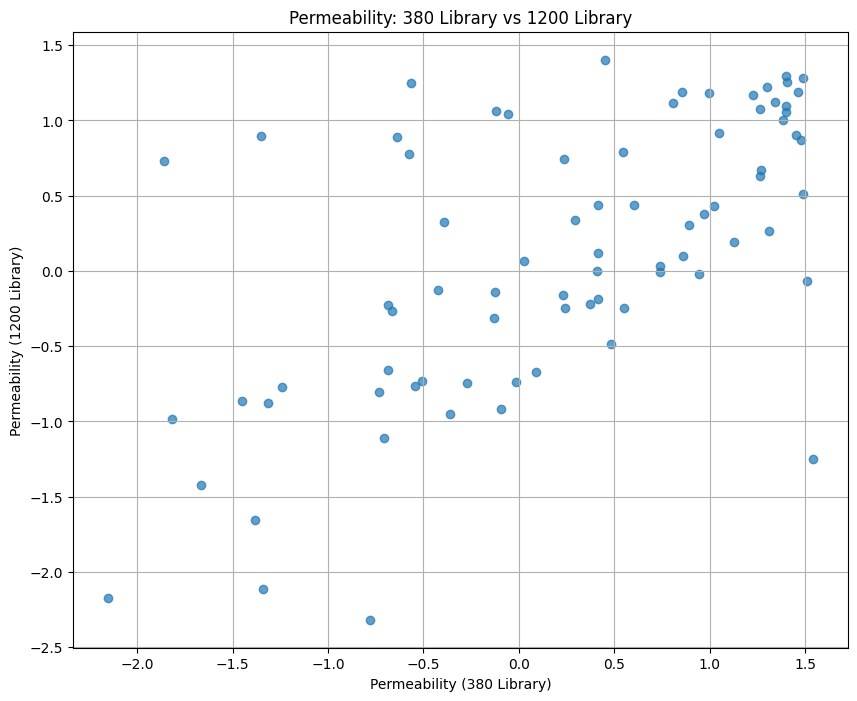

In [ ]:
# visualization of the whole chemical space
smiles_380 = pd.read_excel('20240813_comprehensive_data(2).xlsx', sheet_name = 'smiles_react_perm_380').Smile
smiles_1200 = pd.read_excel('20240813_comprehensive_data(2).xlsx', sheet_name = 'smiles_react_perm_1200').Smile
smiles_40 = pd.read_excel('20240813_comprehensive_data(2).xlsx', sheet_name = 'smiles_react_perm_40').Smile

len(set(smiles_380).intersection(smiles_1200))

def convert_to_mols(smiles_list):
    mols = []
    for sm in smiles_list:
        mol = Chem.MolFromSmiles(sm)
        if mol:
            canonical_smiles = Chem.MolToSmiles(mol, canonical=True)
            mols.append(canonical_smiles)
    return mols

mols_380 = convert_to_mols(smiles_380)
mols_1200 = convert_to_mols(smiles_1200)
mols_40 = convert_to_mols(smiles_40)

print(len(set(mols_1200).intersection(mols_380)))
print(len(set(mols_380).intersection(mols_40)))
print(len(set(mols_1200).intersection(mols_40)))

overlap_380_1200 = set(mols_380).intersection(mols_1200)
# Initialize lists to store the permeability values and corresponding SMILES
permeability_380 = []
permeability_1200 = []
overlapping_smiles = []
y_mtb380 = pd.read_excel('20240813_comprehensive_data(2).xlsx', sheet_name = 'smiles_react_perm_380').mtb_resid_std
y_mtb1200 = pd.read_excel('20240813_comprehensive_data(2).xlsx', sheet_name = 'smiles_react_perm_1200').mtb_resid_std


# Retrieving the corresponding permeability values
for sm in overlap_380_1200:
    index_380 = mols_380.index(sm)
    index_1200 = mols_1200.index(sm)
    permeability_380.append(y_mtb380.iloc[index_380])
    permeability_1200.append(y_mtb1200.iloc[index_1200])
    overlapping_smiles.append(sm)

# Converting to DataFrame for easy plotting
df_overlap = pd.DataFrame({
    'Permeability_380': permeability_380,
    'Permeability_1200': permeability_1200,
    'SMILES': overlapping_smiles  # Add SMILES for hover information
})

# R2 calculation
overlap_r2 = r2_score(permeability_380, permeability_1200)
print('Overlap R2 score between 380 and 1200: ', overlap_r2)
overlap_mse = mean_squared_error(permeability_380, permeability_1200)
print('Overlap MSE score between 380 and 1200: ', overlap_mse)
overlap_rmse = mean_squared_error(permeability_380, permeability_1200, )
print('Overlap RMSE score between 380 and 1200: ', np.sqrt(overlap_rmse))

rho, p_value = spearmanr(permeability_380, permeability_1200)
print('Overlap ranking correlation score between 380 and 1200: ',rho)
print('Overlap p-value score between 380 and 1200: ',p_value) # rejecting the null hypothesis that there is no correlation

# Scatter plot of Permeability values: 380 vs 1200
plt.figure(figsize=(10, 8))
plt.scatter(df_overlap['Permeability_380'], df_overlap['Permeability_1200'], alpha=0.7)
plt.title('Permeability: 380 Library vs 1200 Library')
plt.xlabel('Permeability (380 Library)')
plt.ylabel('Permeability (1200 Library)')
plt.grid(True)
plt.show()


# Plotly interactive plot
fig = px.scatter(
    df_overlap,
    x='Permeability_380',
    y='Permeability_1200',
    hover_name='SMILES',
    labels={
        'Permeability_380': 'Permeability (380 Library)',
        'Permeability_1200': 'Permeability (1200 Library)'
    },
    title='Interactive Permeability Plot: 380 Library vs 1200 Library'
)

# hover information
fig.update_traces(marker=dict(size=10, opacity=0.7), selector=dict(mode='markers'))

# Show the plot
fig.show()
#df_overlap.to_excel('df_overlap.xlsx')

# Scaffold Analysis

## Number of Scaffolds

In [ ]:
def count_scaffolds(csv_path, smiles_column="Smiles"):
    """
    Counts the number of unique scaffolds in a dataset.

    :param csv_path: Path to the dataset (CSV format).
    :param smiles_column: Name of the column containing SMILES strings.
    :return: Number of unique scaffolds.
    """
    # Loading our dataset
    df = pd.read_csv(csv_path)

    # Generating scaffolds
    scaffolds = set()
    for smiles in df[smiles_column].dropna():
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            scaffold = MurckoScaffold.MurckoScaffoldSmiles(mol=mol)
            scaffolds.add(scaffold)

    return len(scaffolds)

csv_path = "PhD paper data with SMILES.csv"
num_scaffolds = count_scaffolds(csv_path)
print(f"Number of unique scaffolds: {num_scaffolds}")


Number of unique scaffolds: 217


## Physical properties - Scaffold analysis

In [ ]:
descriptors = pd.read_csv('Hand_eng_descriptors.csv')

logD = pd.read_excel('cddVisualizationExport_Mon Feb 17 2025.xlsx')['Log D (CDD calculated)']
logS = pd.read_excel('cddVisualizationExport_Mon Feb 17 2025.xlsx')['Log S (CDD calculated)']
cns = pd.read_excel('cddVisualizationExport_Mon Feb 17 2025.xlsx')['CNS MPO score (CDD calculated)']
cns_mean = cns.mean()
cns.fillna(cns_mean, inplace=True)

descriptors['logD'] = logD
descriptors['logS'] = logS
descriptors['CNS MPO score'] = cns
descriptors

scaffolds_smarts = {
    "CYCLOHEXANE": "C1CCCCC1",  # Six-membered saturated ring
    "CYCLOPENTANE": "C1CCCC1",  # Five-membered saturated ring
    "PIPERIDINE": "C1CCNCC1",  # Six-membered ring with one nitrogen
    "PYRROLIDINE": "C1CCNC1",  # Five-membered saturated ring with one nitrogen
    "PYRAZOLE": "n1nccc1",  # Five-membered aromatic ring with two adjacent nitrogens
    "IMIDAZOLE": "c1cncn1",  # Five-membered aromatic ring with non-adjacent nitrogens
    "INDOLE": "c1c[nH]c2c1cccc2",  # Benzene fused with a pyrrole
    "INDAZOLE": "c1ccc2[nH]ncc2c1",  # Benzene fused with a pyrazole
    "PYRIDINE": "c1ccncc1",  # Six-membered aromatic ring with one nitrogen
    "PYRIMIDINE": "c1cncnc1",  # Six-membered aromatic ring with two non-adjacent nitrogens
    "PYRAZINE": "c1cnccn1",  # Six-membered aromatic ring with two adjacent nitrogens
    "QUINOLINE": "c1ccc2ncccc2c1",  # Benzene fused with a pyridine
    "BENZENE": "c1ccccc1",  # Six-membered aromatic ring (benzene)
    "NAPHTHALENE": "c1ccc2ccccc2c1",  # Two fused benzene rings
    "FURAN": "c1ccoc1",  # Five-membered aromatic ring with one oxygen
    "TETRAHYDROFURAN": "C1COCC1",  # Five-membered saturated ring with one oxygen
    "TETRAHYDROPYRAN": "C1CCOCC1",  # Six-membered saturated ring with one oxygen
    "THIOPHENE": "c1ccsc1" , # Five-membered aromatic ring with one sulfur
    #"TRIAZOLE": "n1nncc1",  # Five-membered aromatic ring with three nitrogens

}


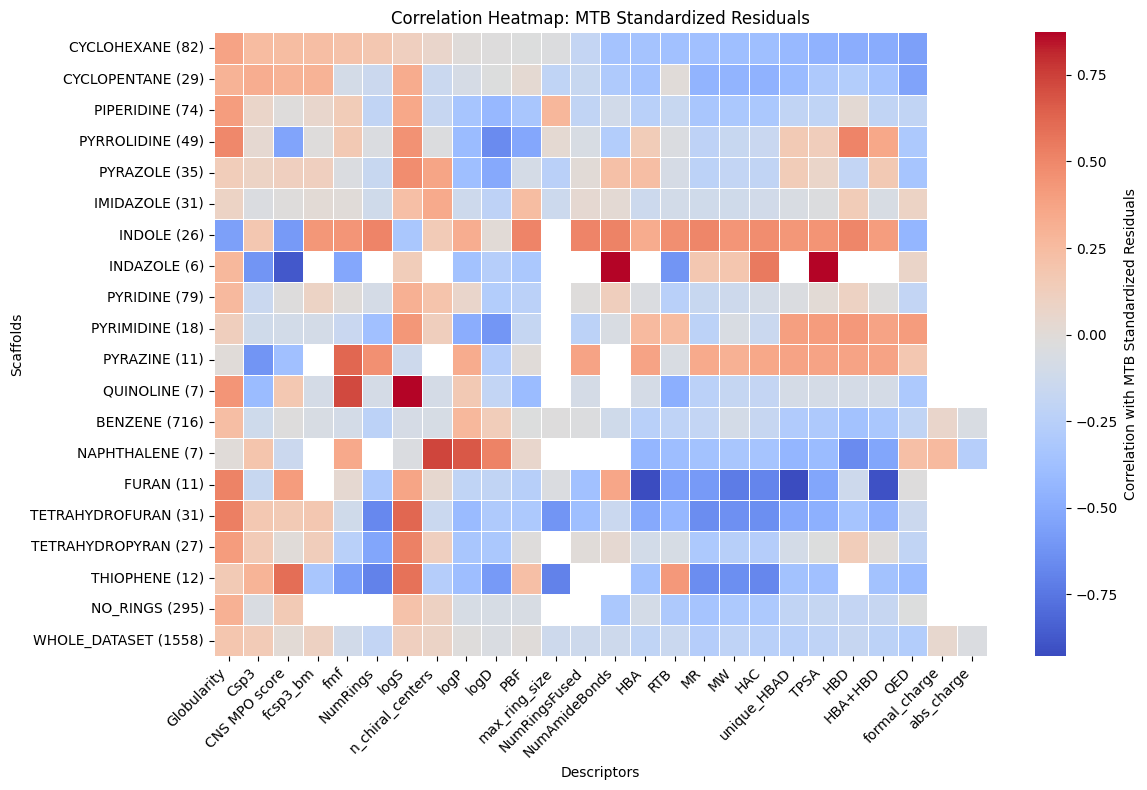

In [ ]:
# Loading the dataset
smiles_series = pd.read_csv('PhD paper data with SMILES.csv').Smiles
y_mtb1600 = df_mtb_1600['MTB Standardized Residuals']
permeability = y_mtb1600.copy()
dataset = pd.concat([smiles_series, descriptors.iloc[:,1::], permeability], axis=1)

# Creating a column to store the SMILES as RDKit Mol objects
PandasTools.AddMoleculeColumnToFrame(dataset, smilesCol='Smiles', molCol='Molecule')

# Initializing dictionaries to store scaffold data and counts
scaffold_dataframes = {}
scaffold_counts = {}

# Iterating over each scaffold and filter the dataframe
for scaffold_name, scaffold_smarts in scaffolds_smarts.items():
    scaffold_mol = Chem.MolFromSmarts(scaffold_smarts)

    # Filtering the rows that contain the scaffold
    df_scaffold = dataset[dataset['Molecule'].apply(lambda mol: mol.HasSubstructMatch(scaffold_mol))]

    # Storing the filtered dataframe and counting of matching compounds
    scaffold_dataframes[scaffold_name] = df_scaffold
    scaffold_counts[scaffold_name] = len(df_scaffold)

# Filtering for compounds without any rings
df_no_rings = dataset[dataset['Molecule'].apply(lambda mol: mol.GetRingInfo().NumRings() == 0)]
scaffold_dataframes['NO_RINGS'] = df_no_rings
scaffold_counts['NO_RINGS'] = len(df_no_rings)

# Adding the whole dataset to the analysis
scaffold_dataframes['WHOLE_DATASET'] = dataset
scaffold_counts['WHOLE_DATASET'] = len(dataset)

# Correlation analysis
correlation_results = {}

for scaffold_name, scaffold_df in scaffold_dataframes.items():
    if not scaffold_df.empty:
        # Ensuring numerical columns only
        combined_df = scaffold_df.drop(columns=['Smiles', 'Molecule']).apply(pd.to_numeric, errors='coerce').dropna(axis=1)

        # Calculating the correlation with 'MTB Standardized Residuals'
        correlation_matrix = combined_df.corr()
        correlation_with_mtb = correlation_matrix['MTB Standardized Residuals'].drop(labels=['MTB Standardized Residuals']).sort_values(ascending=False)

        # Storing the correlation results
        correlation_results[scaffold_name] = correlation_with_mtb

# Saving all results to an Excel file
with pd.ExcelWriter("scaffold_correlations_complete.xlsx") as writer:
    for scaffold_name, corr_df in correlation_results.items():
        corr_df.to_excel(writer, sheet_name=scaffold_name)

# Converting correlation_results dictionary into a DataFrame
correlation_matrix = pd.DataFrame.from_dict(correlation_results, orient='index')

# Modifying row labels to include scaffold counts
scaffold_labels = [f"{scaffold_name} ({scaffold_counts[scaffold_name]})" for scaffold_name in correlation_matrix.index]
correlation_matrix.index = scaffold_labels

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix,
    annot=False,  # Set to True if you want to display values
    cmap='coolwarm',
    cbar_kws={'label': 'Correlation with MTB Standardized Residuals'},
    linewidths=0.5
)
plt.title('Correlation Heatmap: MTB Standardized Residuals')
plt.xlabel('Descriptors')
plt.ylabel('Scaffolds')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Descriptors vs Distributions

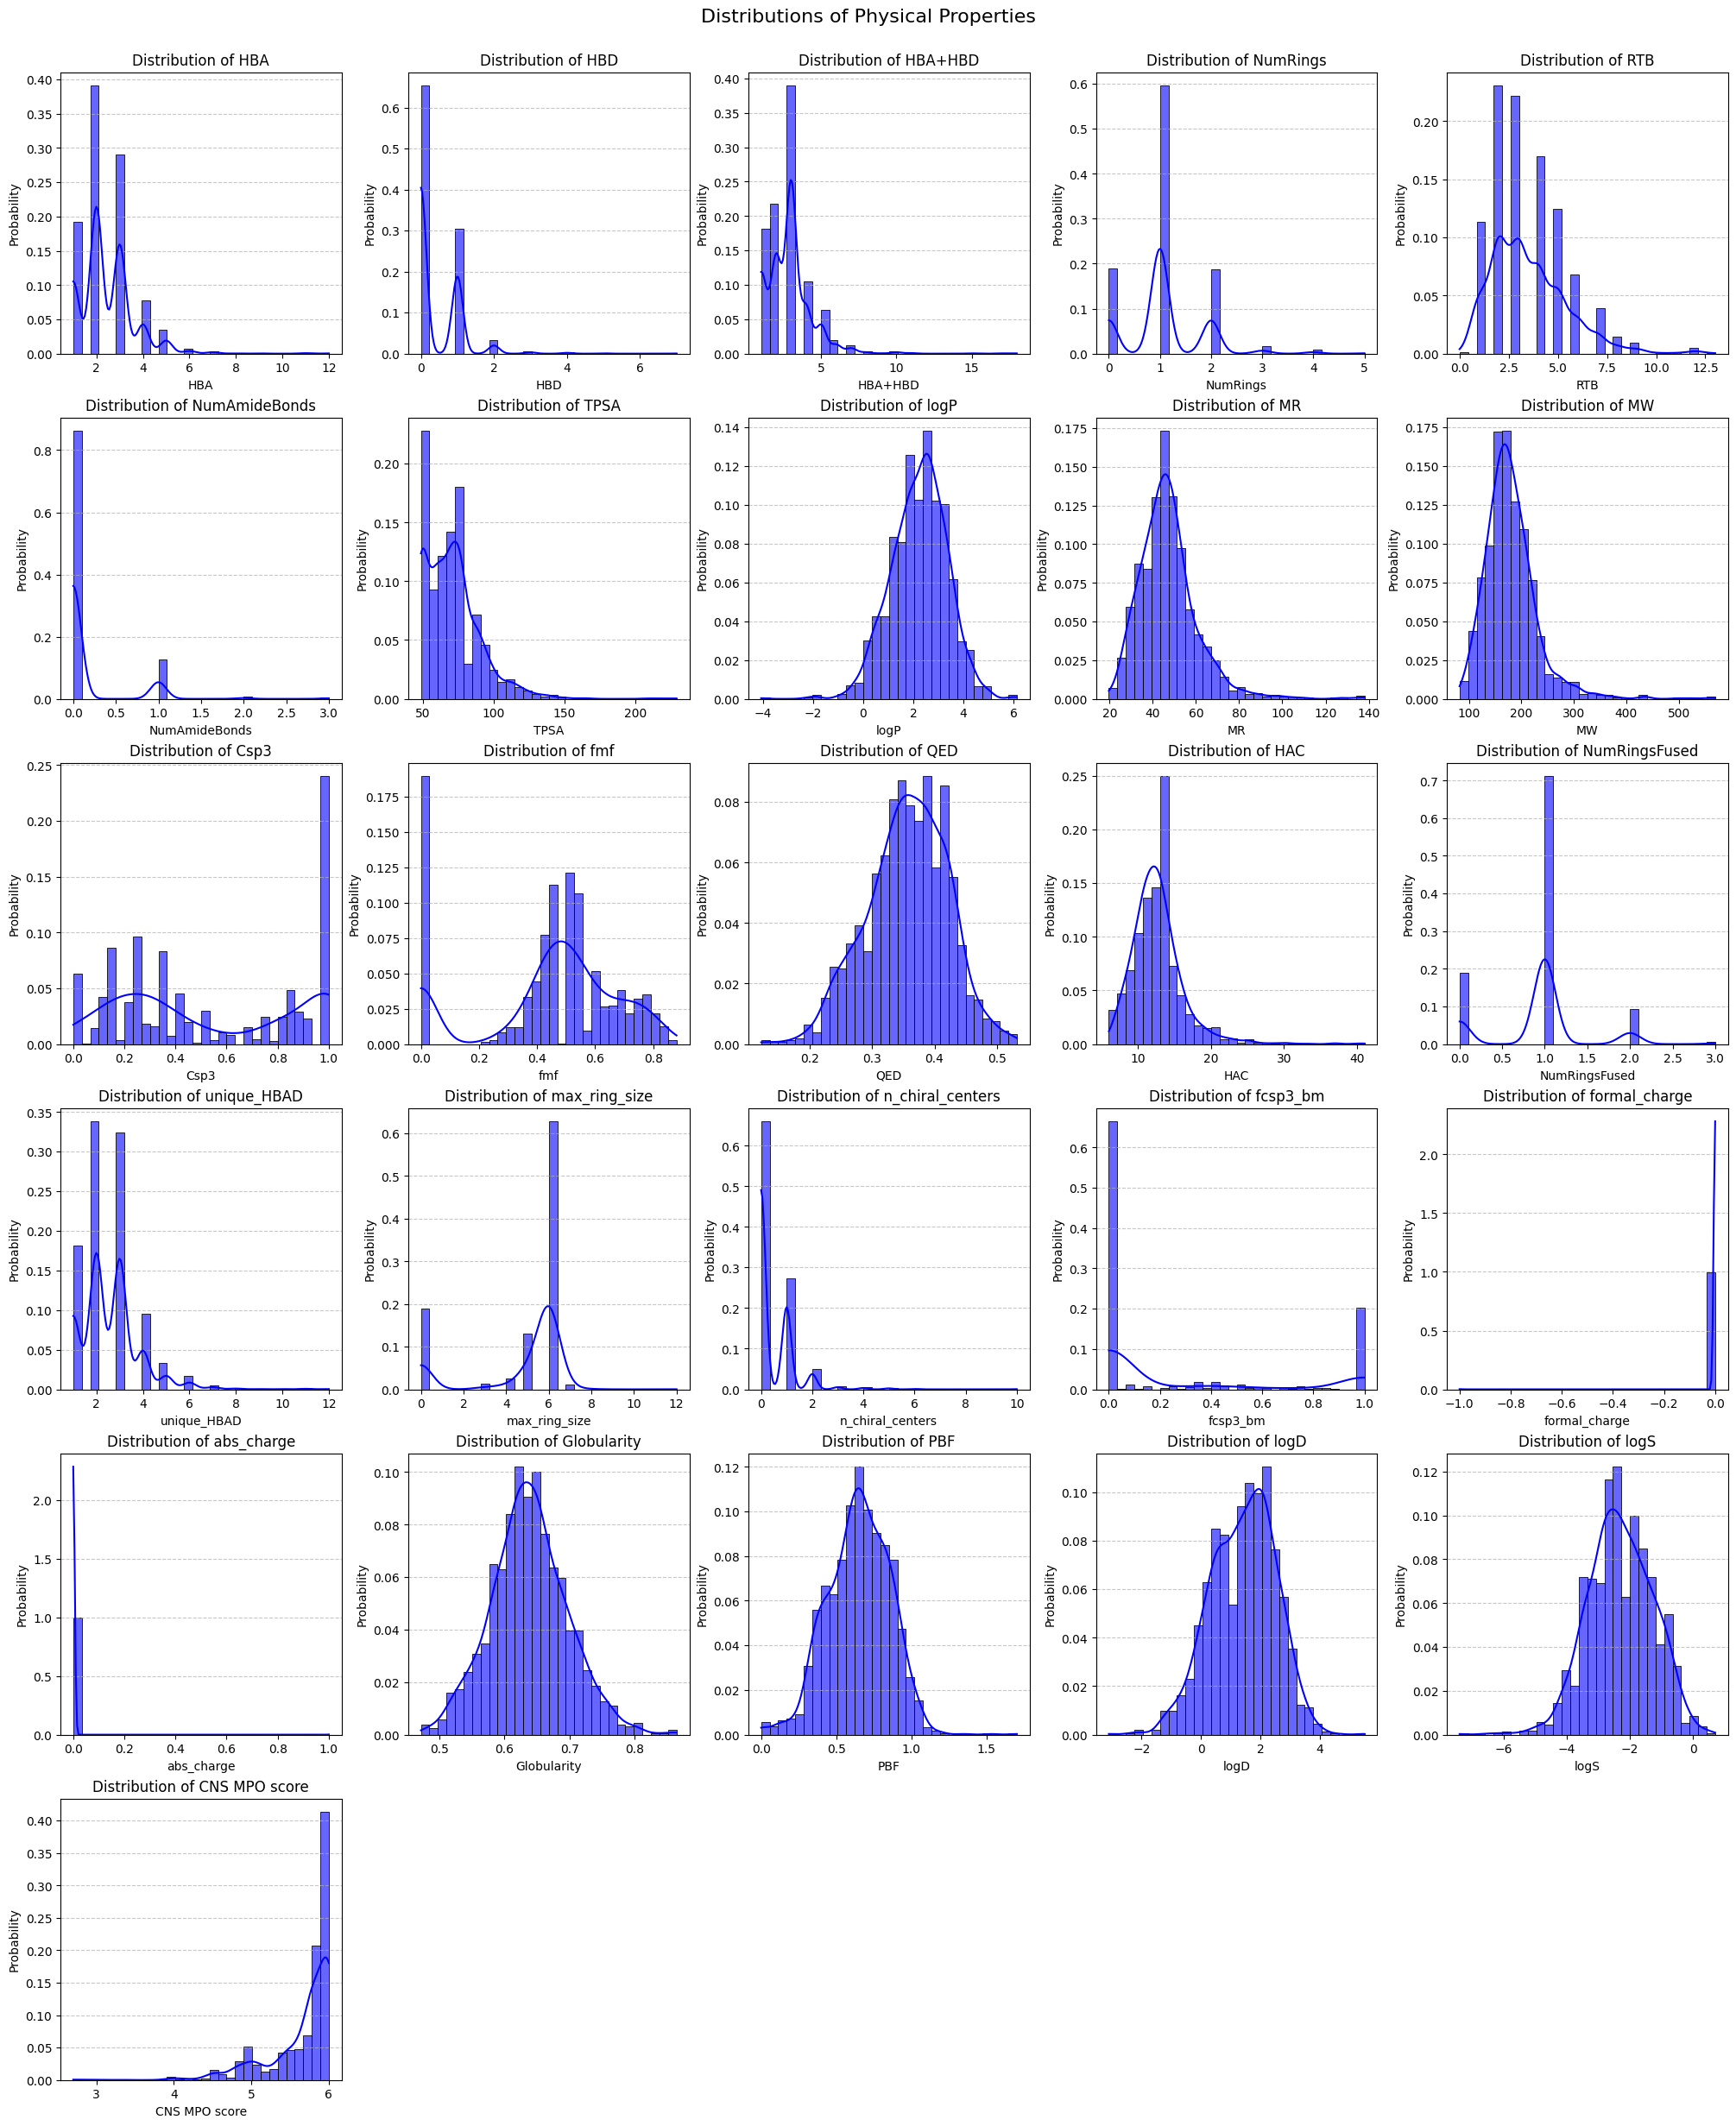

In [ ]:
normalized_descriptors = descriptors.iloc[:,1::].copy() # we preferred to show unnormalized descriptors but feel free to use the normalized version
# Set up the number of rows and columns for the grid layout
num_columns = 5
num_rows = -(-len(normalized_descriptors.columns) // num_columns)  # Ceiling division

# Plots generation
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 4), constrained_layout=True)
axes = axes.flatten()  # Flatten to easily index

# Plotting each property in a subplot
for i, column in enumerate(normalized_descriptors.columns):
    sns.histplot(
        normalized_descriptors[column],
        bins=30,
        kde=True,
        stat="probability",
        ax=axes[i],
        color="blue",
        alpha=0.6
    )
    axes[i].set_title(f"Distribution of {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Probability")
    axes[i].grid(axis="y", linestyle="--", alpha=0.7)

# Turn off any unused subplots
for j in range(len(normalized_descriptors.columns), len(axes)):
    axes[j].axis("off")

plt.suptitle("Distributions of Physical Properties", fontsize=16, y=1.02)
plt.show()


# Version check

In [36]:
!pip show torch
!pip show scipy
!pip show chemprop
!pip show pandas
!pip show numpy
!pip show scikit-learn
!pip show matplotlib
!pip show rdkit
!pip show plotly
!pip show umap-learn

Name: torch
Version: 2.5.1+cu124
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: accelerate, chemprop, fastai, peft, sentence-transformers, timm, torchaudio, torchvision
Name: scipy
Version: 1.13.1
Summary: Fundamental algorithms for scientific computing in Python
Home-page: https://scipy.org/
Author: 
Author-email: 
License: Copyright (c) 2001-2002 Enthought, Inc. 2003-2024, SciPy Developers.
All rights reserved.

Redistribution and use in source and b